Import necessary modules

In [121]:
import numpy as np
import pickle
import os
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline as spline2D
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
%matplotlib notebook

Set up for calculations, and choose for which ne and ns to load jes

In [122]:
ne = 500
ns = 100

def FDdist(en,mu,T):
    if T==0:
        return np.heaviside(mu-en,0.5)
    else:
        return 1.0/(np.exp((en-mu)/T)+1)

jes_comb_path = "jes_combined"#"jes_samesite" #
jes_prefix = "jes-combined"#"jes-samesite"#

# NOTE - mu is in units of eV!
mu_list = [0.4]#[0.3, 0.6, 1]
nmu = len(mu_list)
T = 0

thop = 1 # Hopping parameter (eV)
alatt = 0.246 # Lattice vector (nm)
aCC = alatt/np.sqrt(3) # Carbon-carbon distance (nm)

Find files matching ne, ns and make note of the corresponding disorder w and system size Ntot

In [123]:
file_list = []
w_list = []
Ntot_list = []
nconfig_list = []
note_list = []
onlyfiles = [f for f in os.listdir(jes_comb_path) if os.path.isfile(os.path.join(jes_comb_path, f))]
for file in onlyfiles:
    result = re.search("(.*)%s-w(.*)-ne%s-ns%s-n(.*)-nc(.*).pkl" % (jes_prefix, ne, ns), file)
    if result!=None: # Only try to append matching entries
        file_list.append(result.group(0))
        w_list.append(float(result.group(2)))
        Ntot_list.append(int(result.group(3)))
        nconfig_list.append(int(result.group(4)))
        note_list.append(result.group(1))
nf = len(file_list)
print("Disorder strengths for each file:")
print(w_list)
print("Number of unit cells for each file:")
print(Ntot_list)
print("Number of disorder configs for each file:")
print(nconfig_list)
print("Notes on each file")
print(note_list)

Disorder strengths for each file:
[1.0, 1.0, 1.0, 1.0, 1.0]
Number of unit cells for each file:
[1296, 14400, 2601, 5625, 576]
Number of disorder configs for each file:
[700, 10, 2600, 100, 2000]
Notes on each file
['', '', '', '', '']


Load the files

In [124]:
jes = np.zeros((ne,ns,nf))
num_deltas = np.zeros((ne,ns,nf))
dos = np.zeros((ne,nf))
emin = np.zeros((nf))
emax = np.zeros((nf))
for kf, file in enumerate(file_list):
    with open(jes_comb_path+"/"+file, "rb") as infile:
        jes_temp, emin[kf], emax[kf], smin, smax, num_deltas[:,:,kf], dos[:,kf] = pickle.load(infile)
    # Normalize jes and the JDoS. Without normalization, each is proportional to (2*Ntot)^2/(ne*ns)
    jes[:,:,kf] = jes_temp*ne*ns/(2*Ntot_list[kf])
    num_deltas[:,:,kf] = num_deltas[:,:,kf]*ne*ns/(2*Ntot_list[kf])
    # Normalize the DoS
    dos[:,kf] = dos[:,kf]*ne/(2*Ntot_list[kf])

print("Done")

rescaleflag = 0 # Indicate that the energies have NOT been rescaled and are in units of t

Done


Set the energy scale

In [125]:
# Energy parameters to adjust: emin, emax, smin, smax, 
# Note that mu is already in units of eV

en_scale = np.abs(thop)
len_scale = aCC

if rescaleflag==0:
    jes = jes*(len_scale**2)
    smin = smin*en_scale
    smax = smax*en_scale
    for kf in np.arange(nf):
        emin[kf] = emin[kf]*en_scale
        emax[kf] = emax[kf]*en_scale

    rescaleflag = 1
    print("Energies and lengths rescaled")
else:
    print("Energies and lengths have already been rescaled")

Energies and lengths rescaled


Calculate the conductivity for all disorders and various Fermi levels

In [126]:
FDfactor = np.zeros((ne,ns,nmu))
sig = np.zeros((ns,nf,nmu))
for kf in np.arange(nf):
    ewidth = emax[kf]-emin[kf]
    de = ewidth/ne
    swidth = smax-smin
    ds = swidth/ns
    # Bin centers
    evec = np.linspace(emin[kf], emax[kf]-de, ne) + de/2
    svec = np.linspace(smin, smax-ds, ns) + ds/2
    [ss, ee] = np.meshgrid(svec, evec)
    for kmu, mu in enumerate(mu_list):
        FDfactor[:,:,kmu] = np.divide( (FDdist(ee+ss/2,mu,T)-FDdist(ee-ss/2,mu,T)) , ss )
        # Don't forget to multiply by the area element de; do it here not at the end because de changes between files
        # Also, jes should have been an average over a continuous s but my code calculates it as just the integral; to fix that, divide by ds
        sig[:,kf,kmu] = -de*np.pi*(np.multiply( jes[:,:,kf] , FDfactor[:,:,kmu] )).sum(axis=0)

for kmu, mu in enumerate(mu_list):
    if FDfactor[:,0,kmu].any()==False:
        print("Warning: s=0 missed by binning in e direction at Fermi level index %d with value %f\n" % (kmu, mu))

print("Done")


Done


Plot the result

0.009999999999999998


<IPython.core.display.Javascript object>


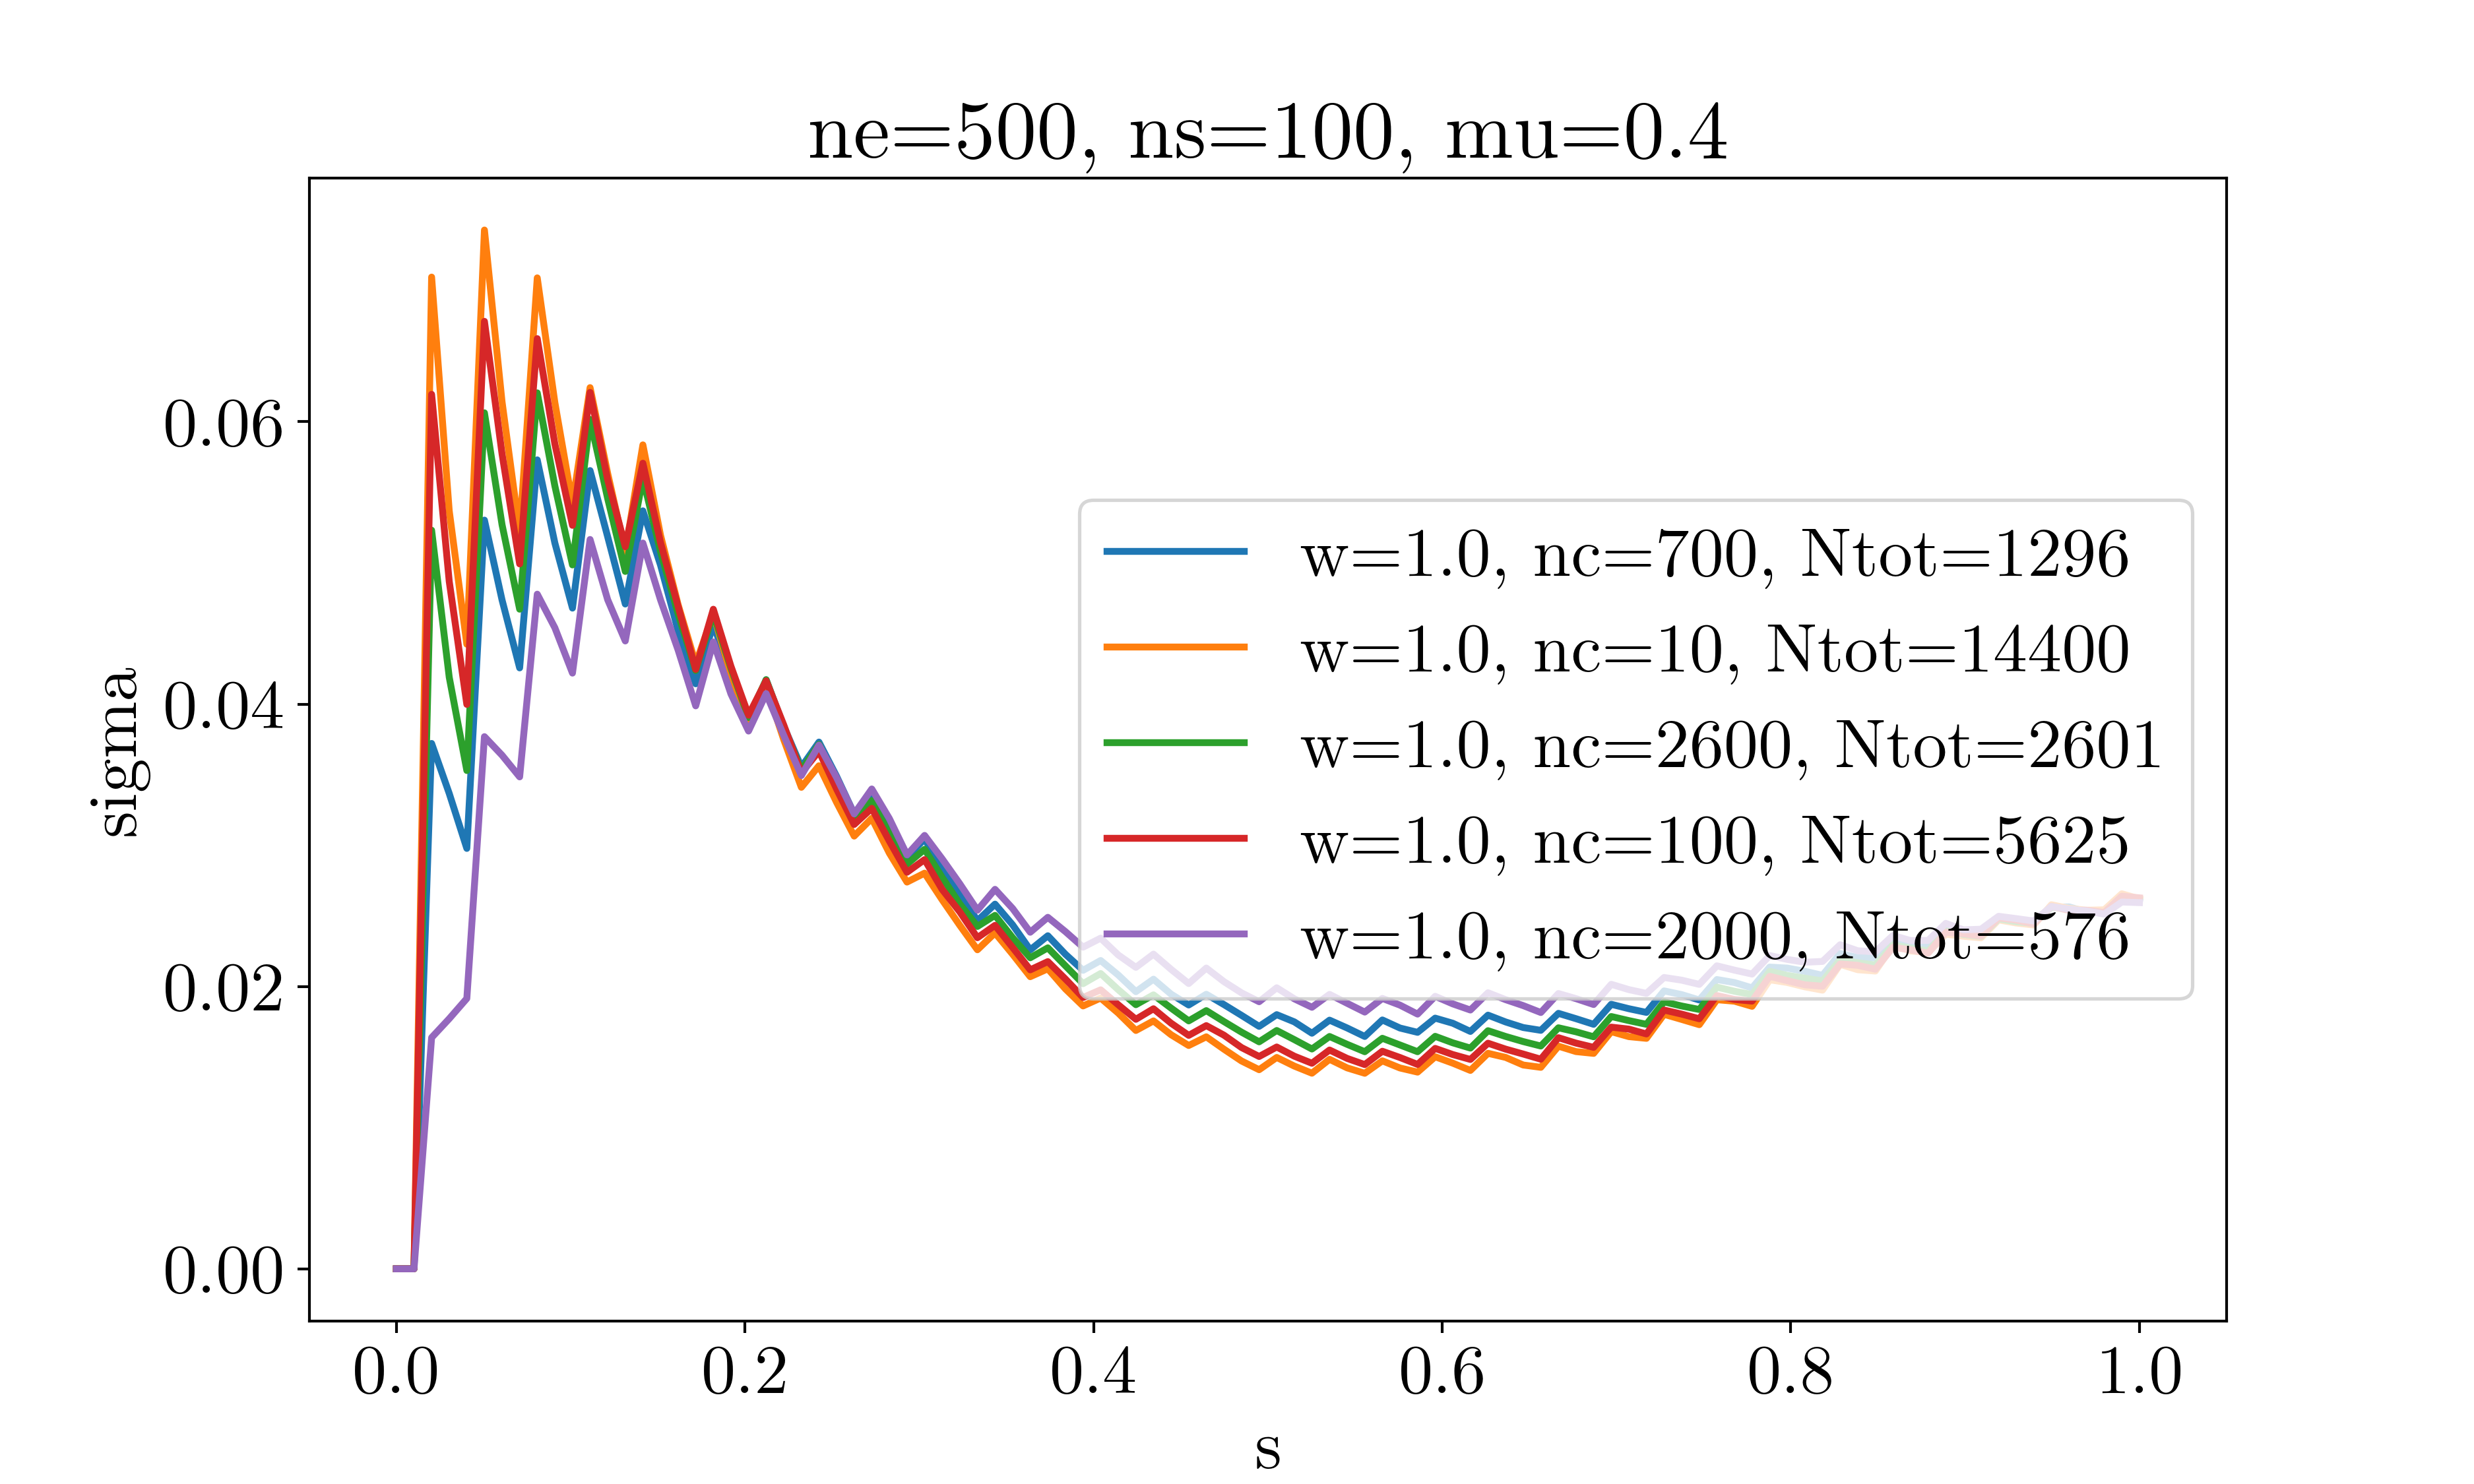

<IPython.core.display.Javascript object>


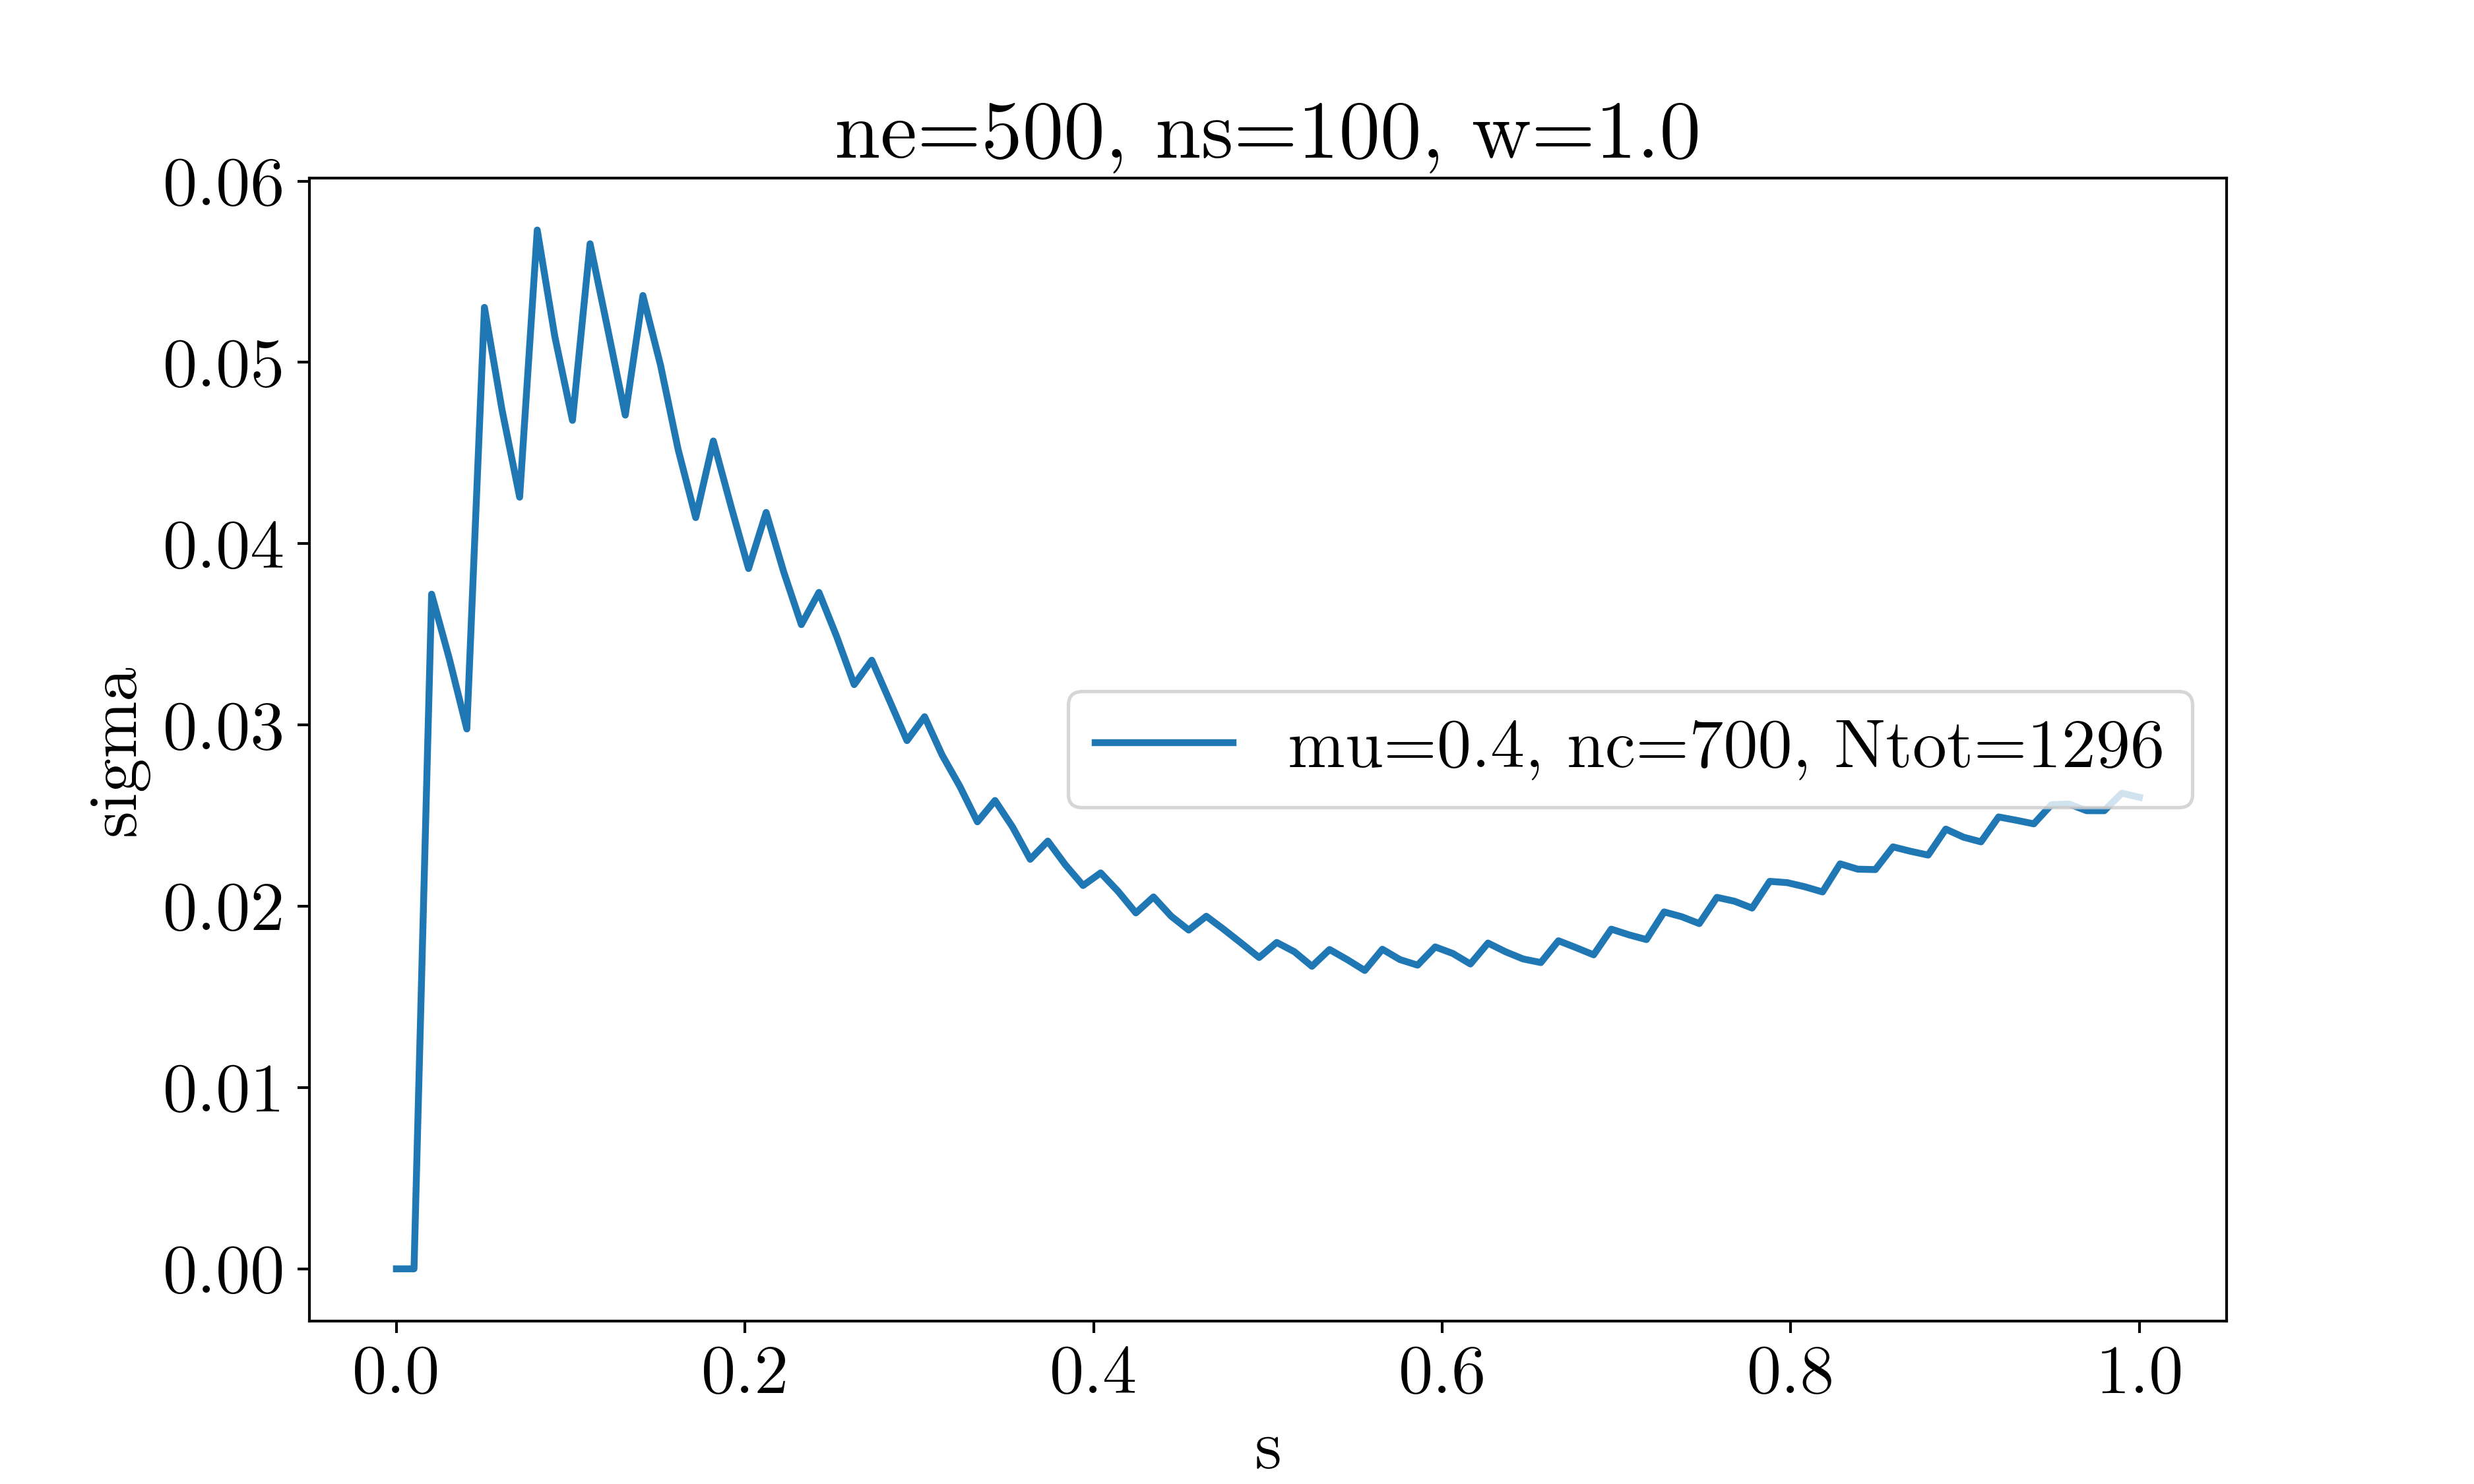

In [79]:
kmu_plot = 0
print(ds)
svec = np.linspace(smin, smax, ns)
plt.figure(0,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
for kf in np.arange(nf):
    plt.plot(svec, sig[:,kf,kmu_plot], label=("w=%s, nc=%s, Ntot=%s" % (w_list[kf],nconfig_list[kf],Ntot_list[kf])))
ax0 = plt.gca()
#ax0.set_ylim([0,3])
ax0.set_title("ne=%d, ns=%d, mu=%s" % (ne,ns,mu_list[kmu_plot]))
ax0.set_xlabel("s")
ax0.set_ylabel("sigma")
plt.legend(loc=5)

plt.figure(100,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
kf_plot = 0
for kmu, mu in enumerate(mu_list):
    plt.plot(svec, sig[:,kf_plot,kmu], label=("mu=%s, nc=%s, Ntot=%s" % (mu,nconfig_list[kf_plot],Ntot_list[kf_plot])))
ax0 = plt.gca()
ax0.set_title("ne=%d, ns=%d, w=%s" % (ne, ns, w_list[kf_plot]))
ax0.set_xlabel("s")
ax0.set_ylabel("sigma")
plt.legend(loc=5)

Create splines of jes

In [109]:
jesspline = []
for kf in np.arange(nf):
    ewidth = emax[kf]-emin[kf]
    de = ewidth/ne
    swidth = smax-smin
    ds = swidth/ns
    # Bin centers
    evec = np.linspace(emin[kf], emax[kf]-de, ne) + de/2
    svec = np.linspace(smin, smax-ds, ns) + ds/2
    jesspline.append( spline2D(evec, svec, jes[:,:,kf], s=0.005) )

print("Done")

Done


Calculate conductivity with splines

In [110]:
sigsplined = np.zeros((ns,nf,nmu))
for kf in np.arange(nf):
    print("Now on file %s of %s" % (kf+1, nf))
    ewidth = emax[kf]-emin[kf]
    de = ewidth/ne
    swidth = smax-smin
    ds = swidth/ns
    # Bin centers
    evec = np.linspace(emin[kf], emax[kf]-de, ne) + de/2
    svec = np.linspace(smin, smax-ds, ns) + ds/2
    [ss, ee] = np.meshgrid(svec, evec)
    for kmu, mu in enumerate(mu_list):
        print("Fermi level %s of %s" % (kmu+1, nmu))
        for ks, s in enumerate(svec):
            if T==0:
                # Cut off the integral at the sharp edges of the allowed interval in e
                emin_zeroT = mu - s/2
                emax_zeroT = mu + s/2
                def sig_integrand(ee):
                    return jesspline[kf](ee, s)/(s)
                sigsplined[ks,kf,kmu] = quad(sig_integrand, emin_zeroT, emax_zeroT)[0]
            else:
                # Integrate over the entire region
                def sig_integrand(ee):
                    FDfactor = ( FDdist(ee+s/2, mu, T) - FDdist(ee-s/2, mu, T) )/(s)
                    return np.multiply(jesspline[kf](ee, s), FDfactor)
                sigsplined[ks,kf,kmu] = quad(sig_integrand, emin, emax)[0]

print("Done")

Now on file 1 of 5
Fermi level 1 of 1
Now on file 2 of 5
Fermi level 1 of 1
Now on file 3 of 5
Fermi level 1 of 1
Now on file 4 of 5
Fermi level 1 of 1
Now on file 5 of 5
Fermi level 1 of 1
Done


Plot conductivity calculated with splines

<IPython.core.display.Javascript object>


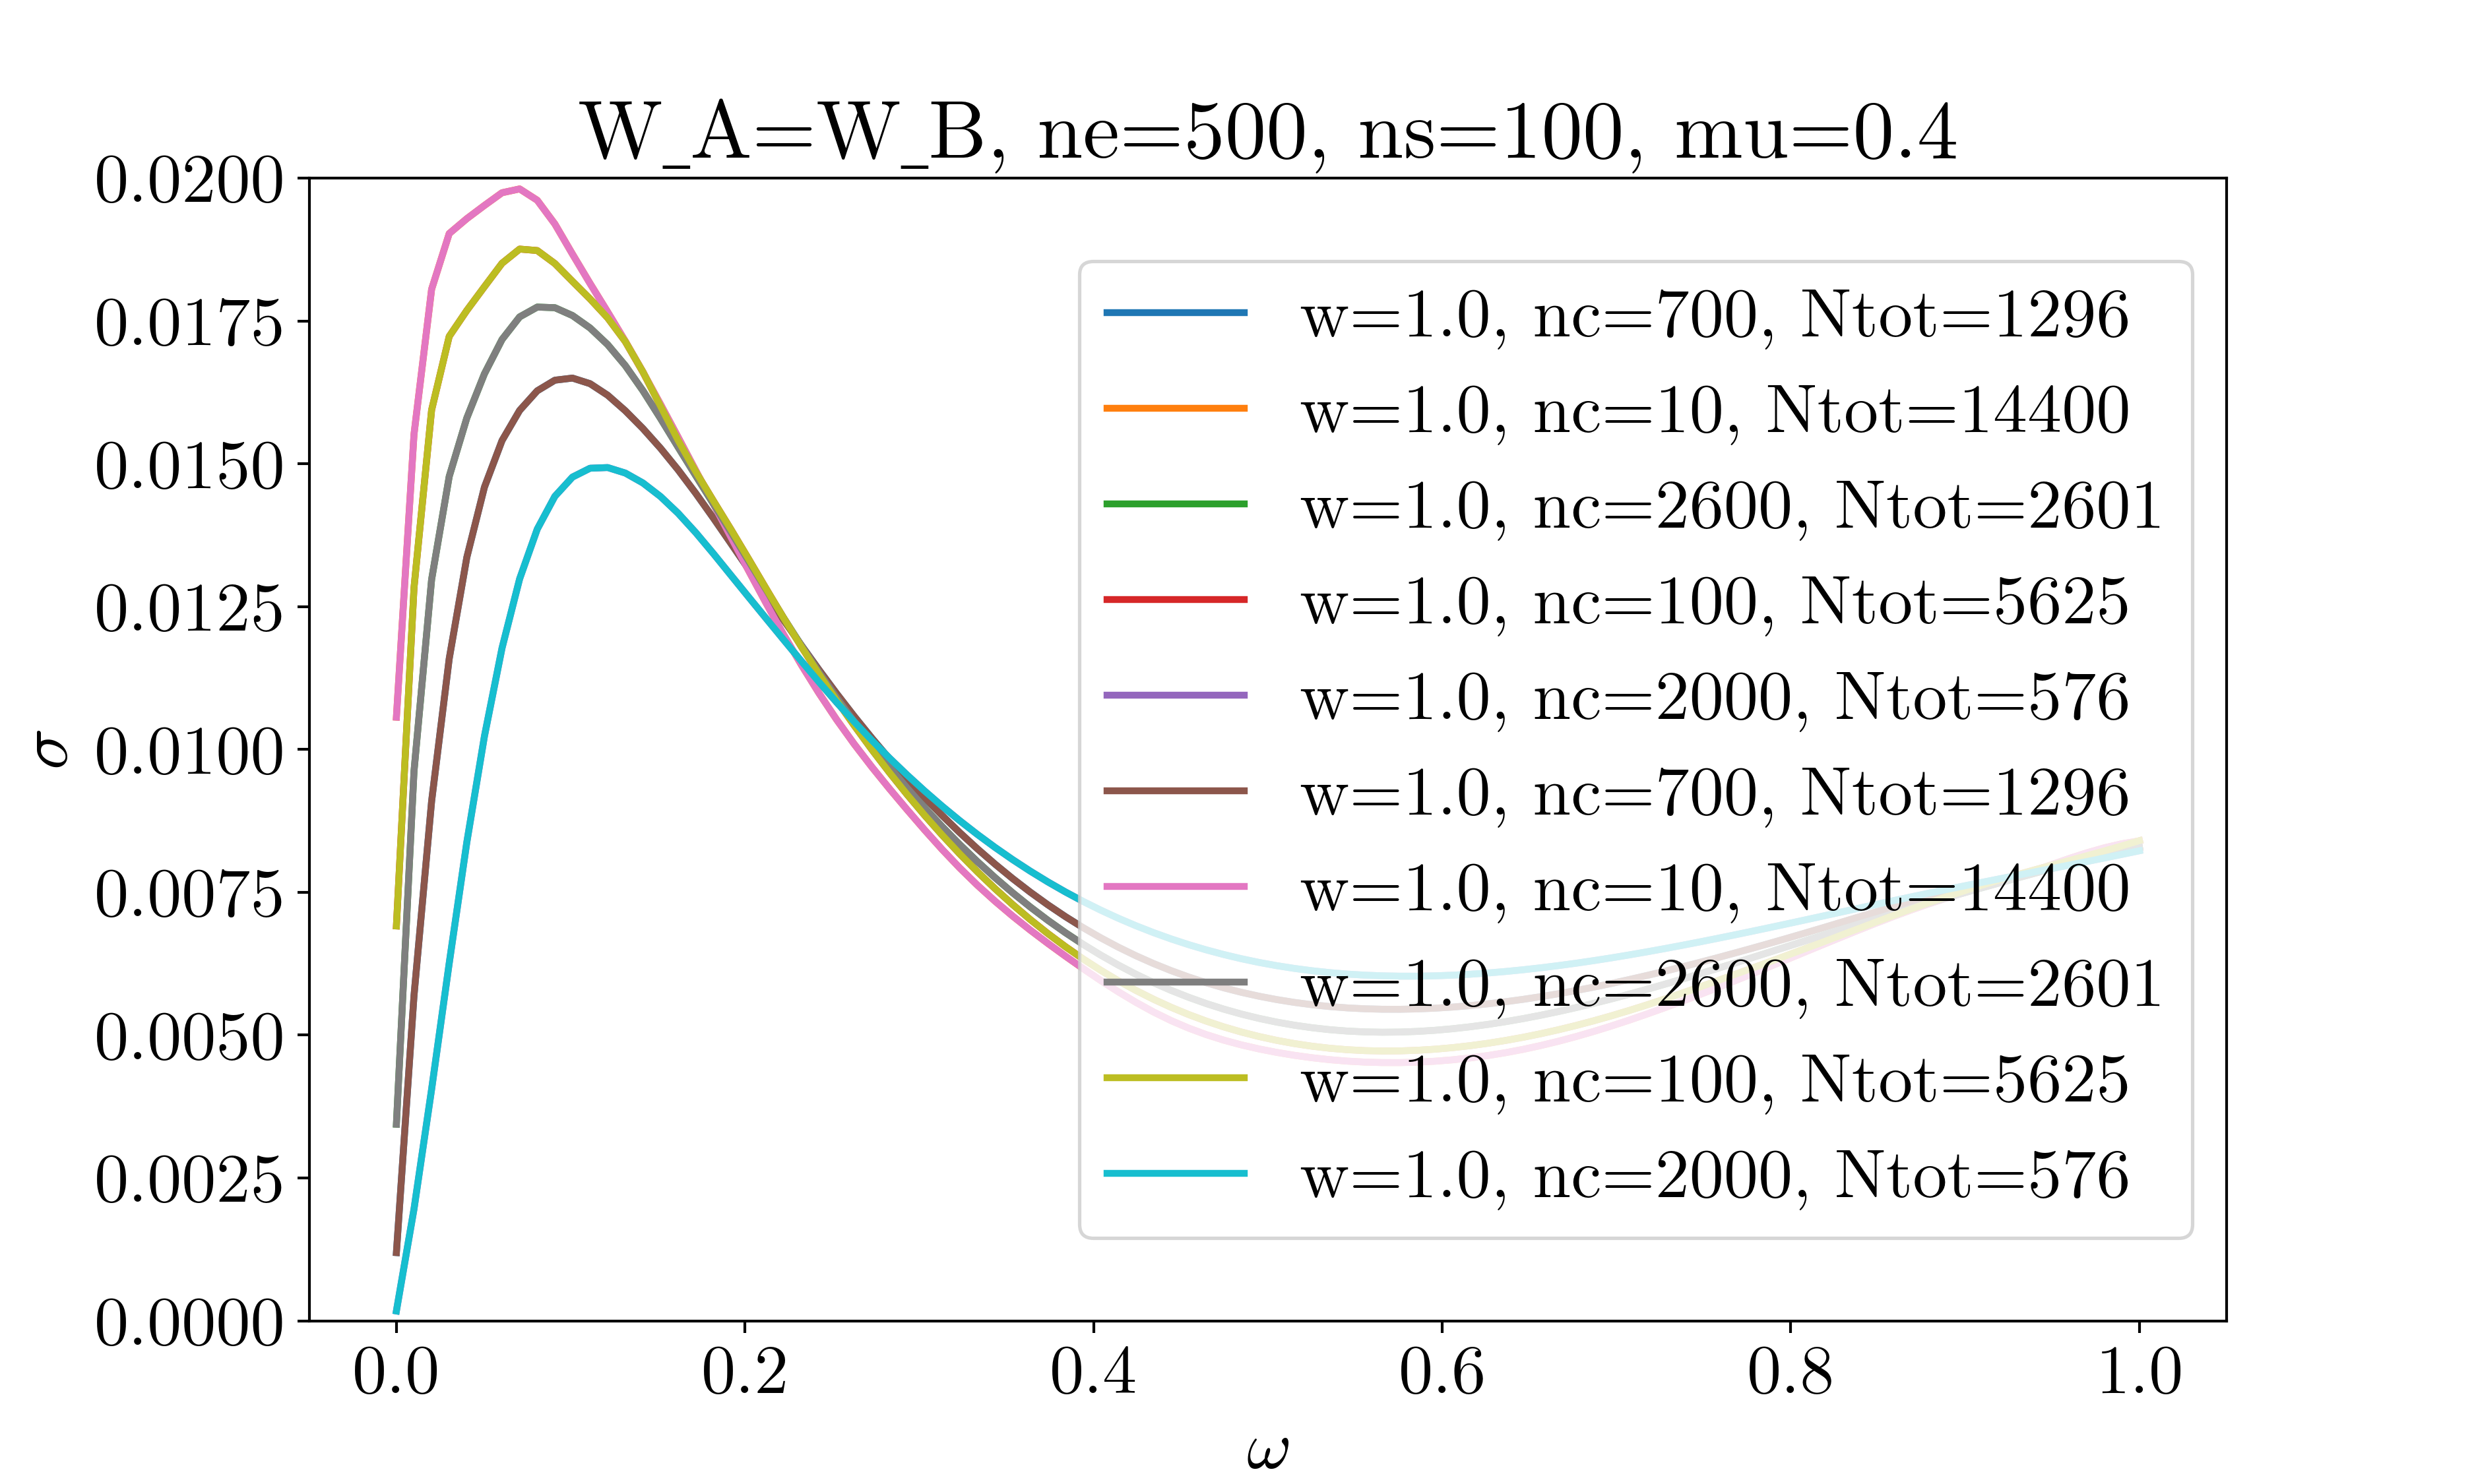

<IPython.core.display.Javascript object>


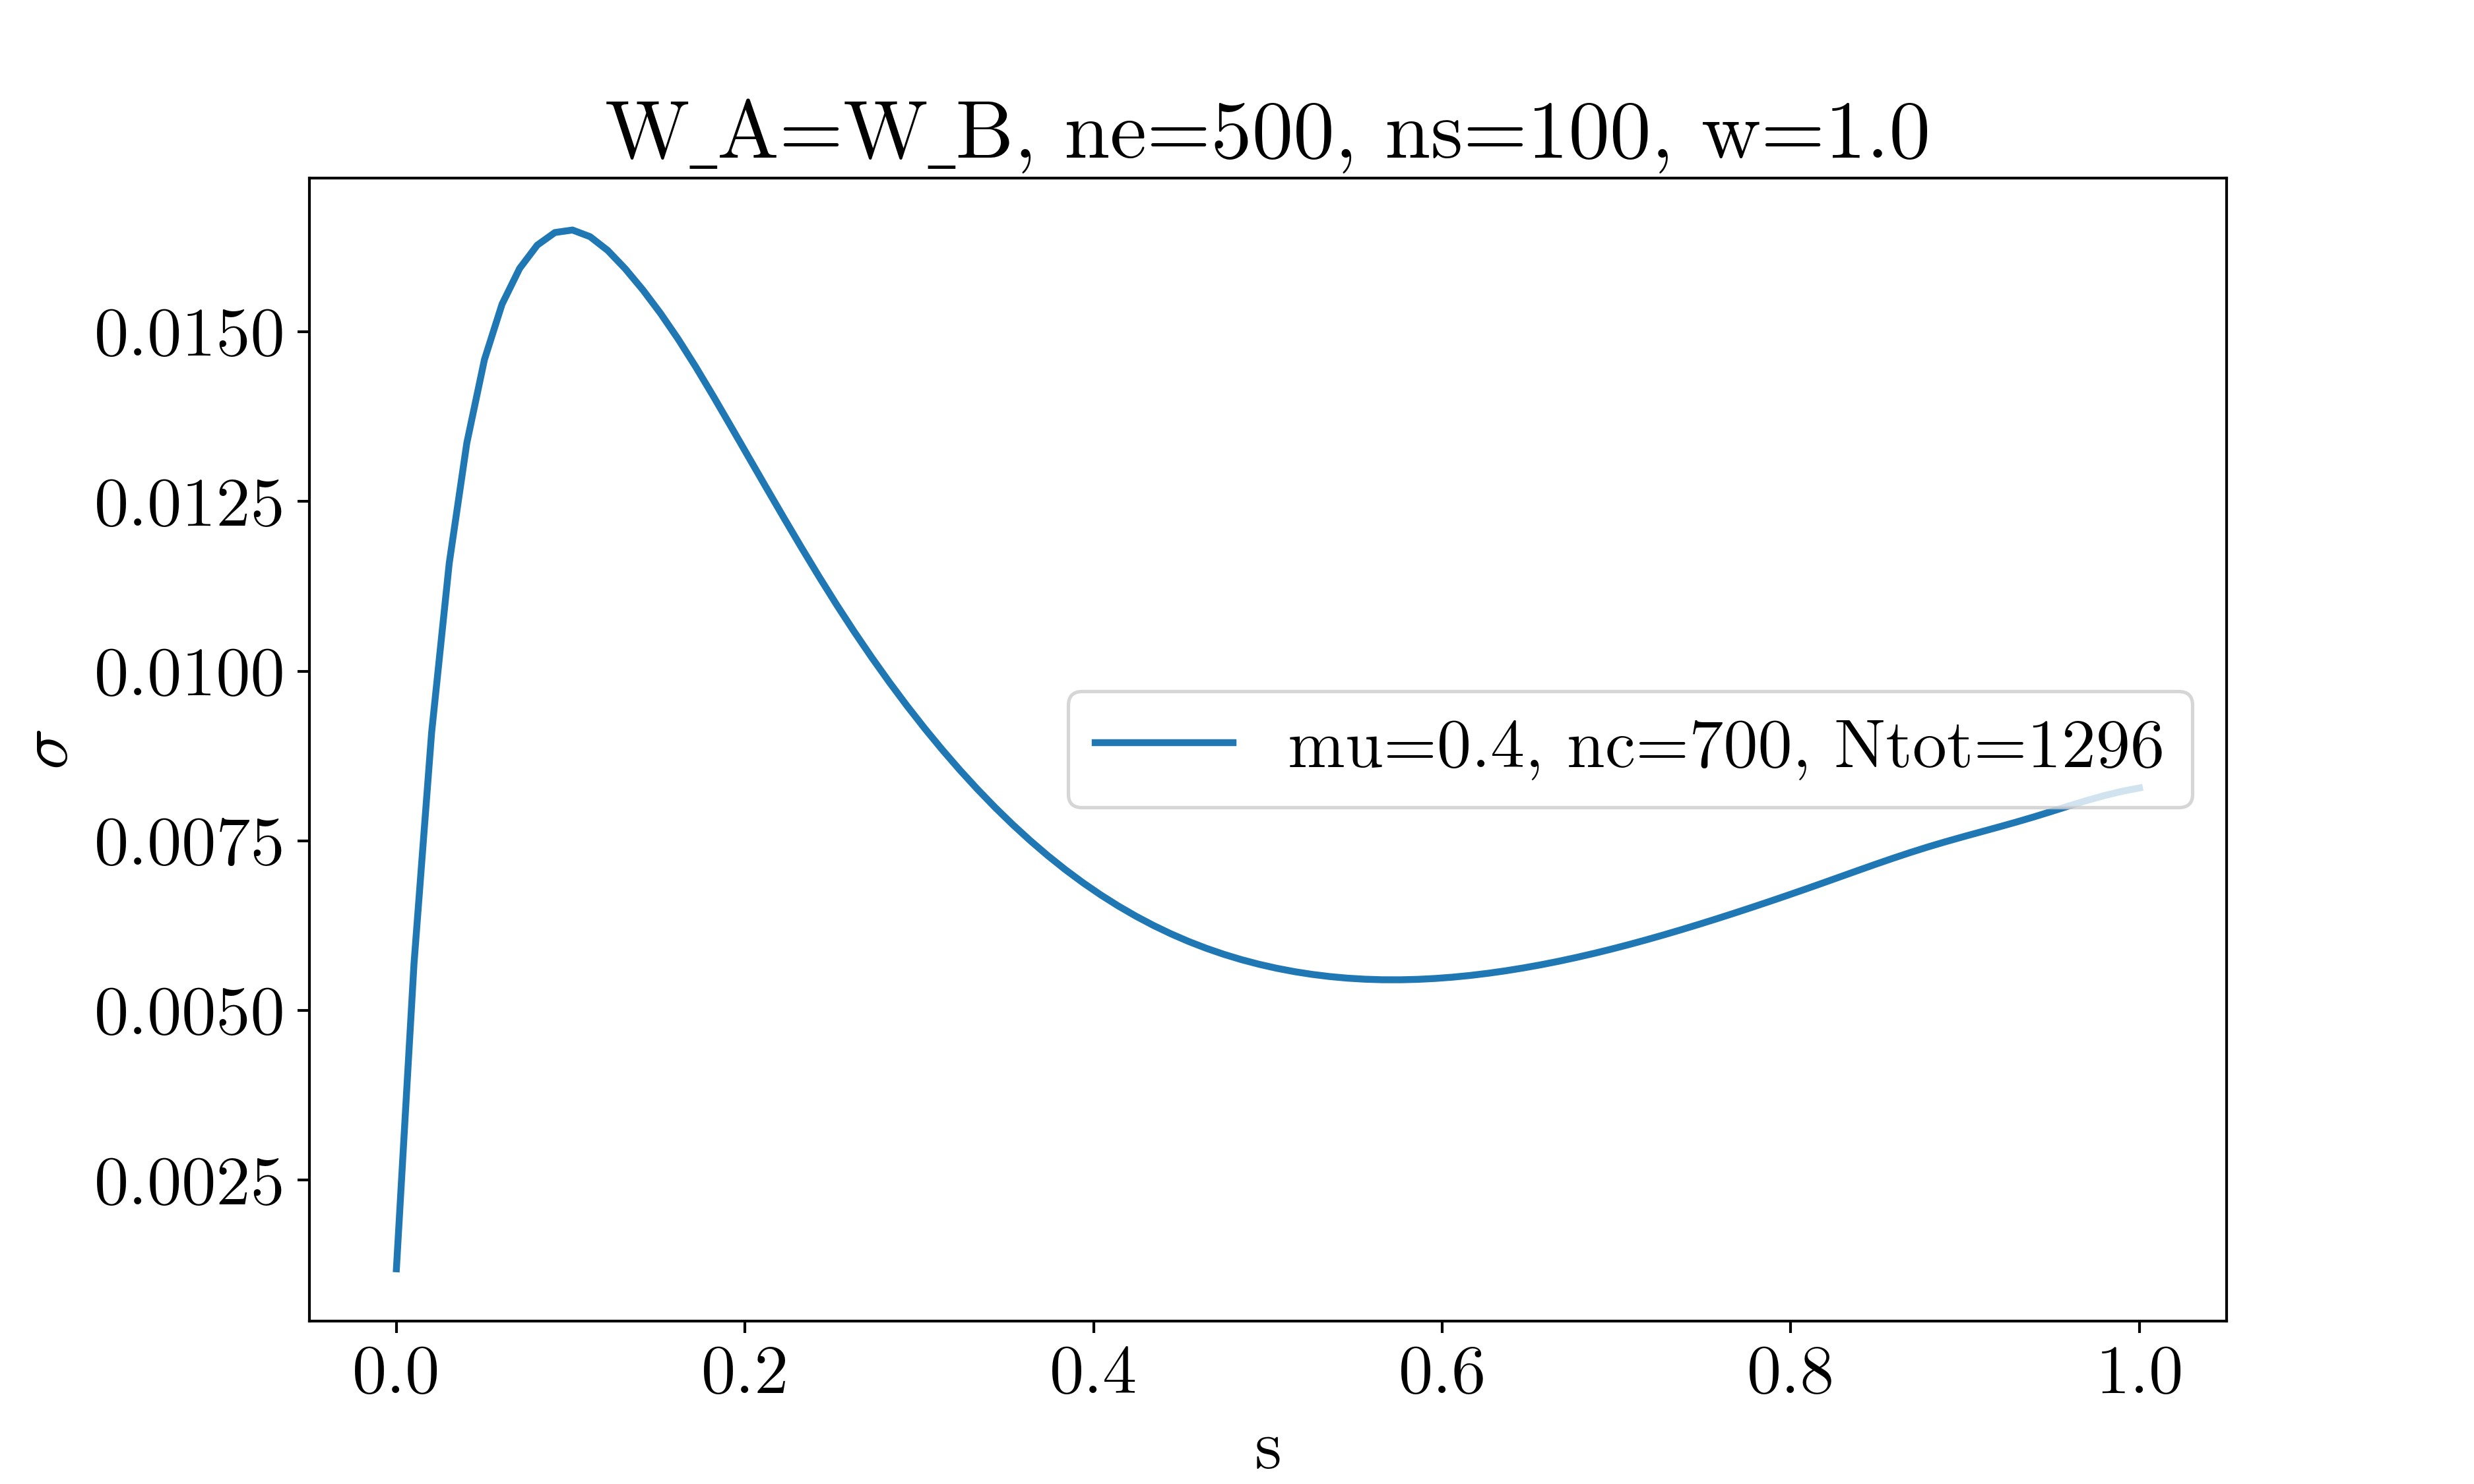

In [111]:
kmu_plot = 0

svec = np.linspace(smin, smax, ns)
plt.figure(201,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
for kf in np.arange(nf):
    plt.plot(svec, sigsplined[:,kf,kmu_plot], label=("w=%s, nc=%s, Ntot=%s" % (w_list[kf],nconfig_list[kf],Ntot_list[kf])))
#    plt.plot(svec, sigsplined[:,kf,kmu_plot], dashes=[1], label=("w=%s, nc=%s, Ntot=%s" % (w_list[kf],nconfig_list[kf],Ntot_list[kf])))
ax0 = plt.gca()
ax0.set_title("W_A=W_B, ne=%d, ns=%d, mu=%s" % (ne,ns,mu_list[kmu_plot]))
ax0.set_xlabel("$\omega$")
ax0.set_ylabel("$\sigma$")
ax0.set_ylim([0, 0.02])
plt.legend(loc=5)

'''
kmu_plot = 2
svec = np.linspace(smin, smax, ns)
plt.figure(201,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
for kf in np.arange(1,nf):
    plt.plot(2.7*svec, sigsplined[:,kf,kmu_plot], label=("w=%s, nc=%s, Ntot=%s" % (w_list[kf],nconfig_list[kf],Ntot_list[kf])))
ax0 = plt.gca()
from matplotlib import rc
font = {"family" : "Computer Modern Roman", "size" : 20}
rc('font', **font)
ax0.set_title("KG conductivity")
ax0.set_xlabel("ω (eV)")
ax0.set_ylabel("σ")
ax0.set_ylim([0, 1])
#plt.legend(loc=5)
'''

plt.figure(202,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
kw_plot = 0
for kmu, mu in enumerate(mu_list):
    plt.plot(svec, sigsplined[:,kw_plot,kmu], label=("mu=%s, nc=%s, Ntot=%s" % (mu,nconfig_list[kw_plot],Ntot_list[kw_plot])))
ax0 = plt.gca()
ax0.set_title("W_A=W_B, ne=%d, ns=%d, w=%s" % (ne, ns, w_list[kw_plot]))
ax0.set_xlabel("s")
ax0.set_ylabel("$\sigma$")
plt.legend(loc=5)


Plot the splined jes

w=1.0


<IPython.core.display.Javascript object>


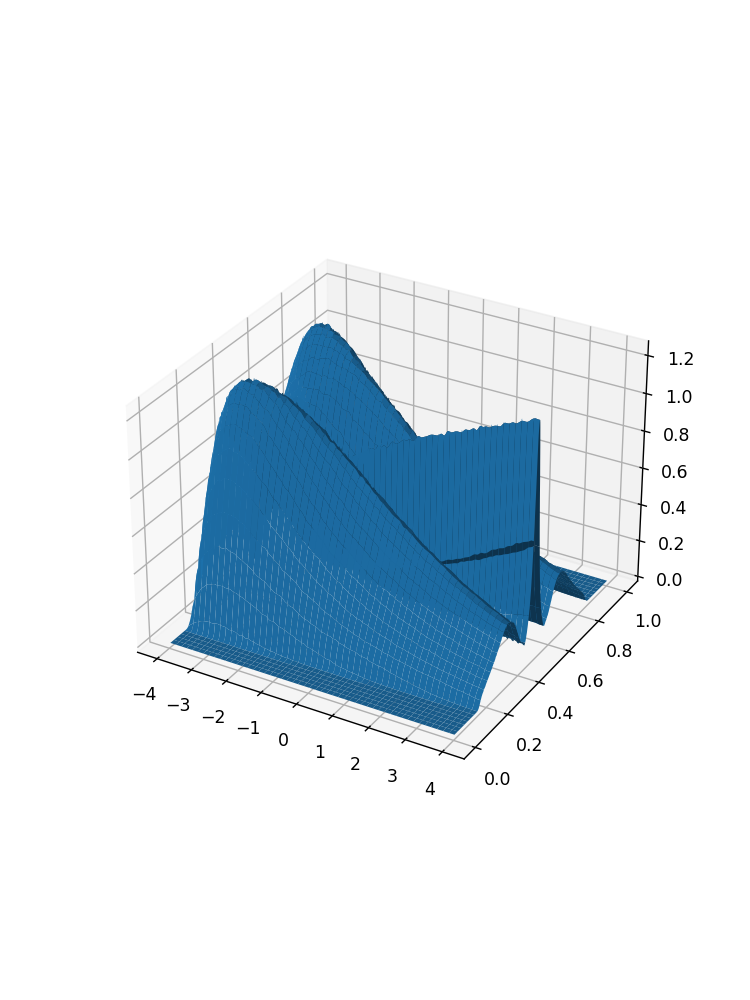

In [54]:
kf_plot = 0
eplotres = 1000
splotres = 1000

ewidthspline = emax[kf_plot]-emin[kf_plot]
despline = ewidth/eplotres
swidthspline = smax-smin
dsspline = swidthspline/splotres
# Bin centers
evecspline = np.linspace(emin[kf_plot], emax[kf_plot]-despline, eplotres) + de/2
svecspline = np.linspace(smin, smax-dsspline, splotres) + ds/2
[eespline, ssspline] = np.meshgrid(evecspline, svecspline)
print("w=%s" % w_list[kf_plot])

zz = jesspline[kf_plot](evecspline, svecspline)
fig30 = plt.figure(30, figsize=(6,8))
ax30 = plt.axes(projection="3d")
ax30.plot_surface(eespline, ssspline, zz)

Plot various useful figures

w=1.0
mu=0.1
s=0.034999999999999996


<IPython.core.display.Javascript object>


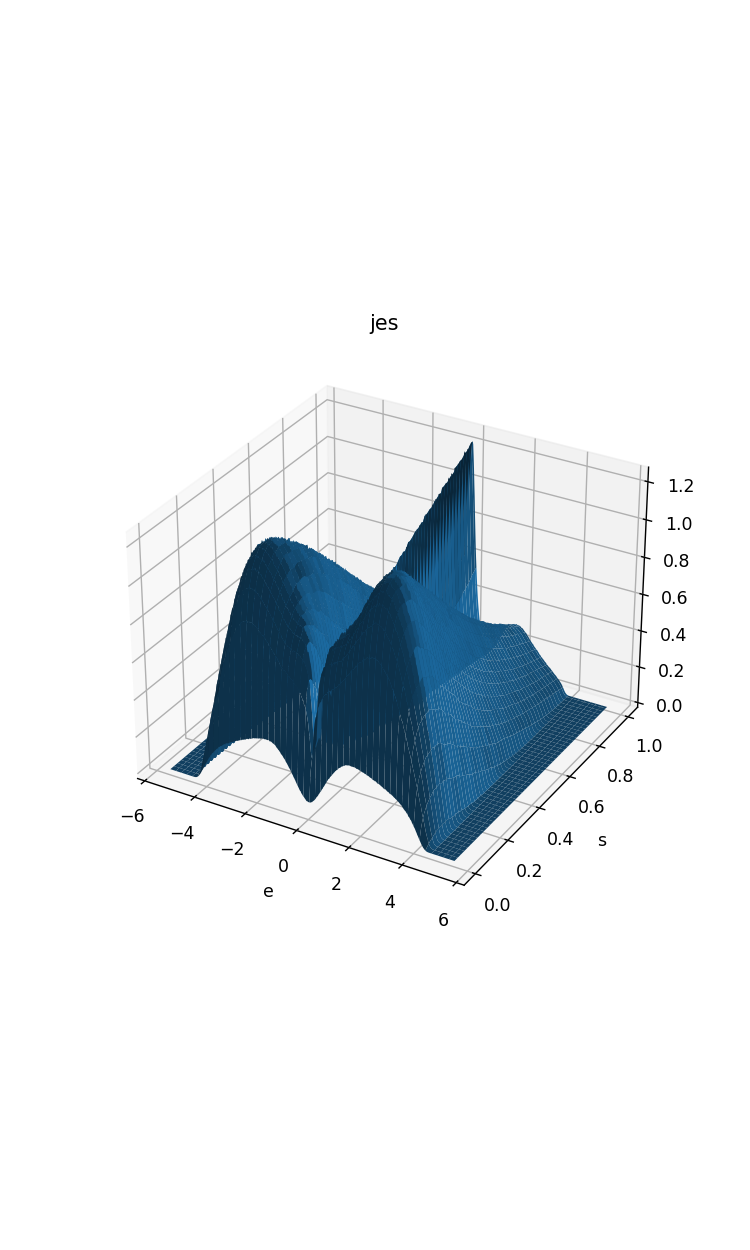

<IPython.core.display.Javascript object>


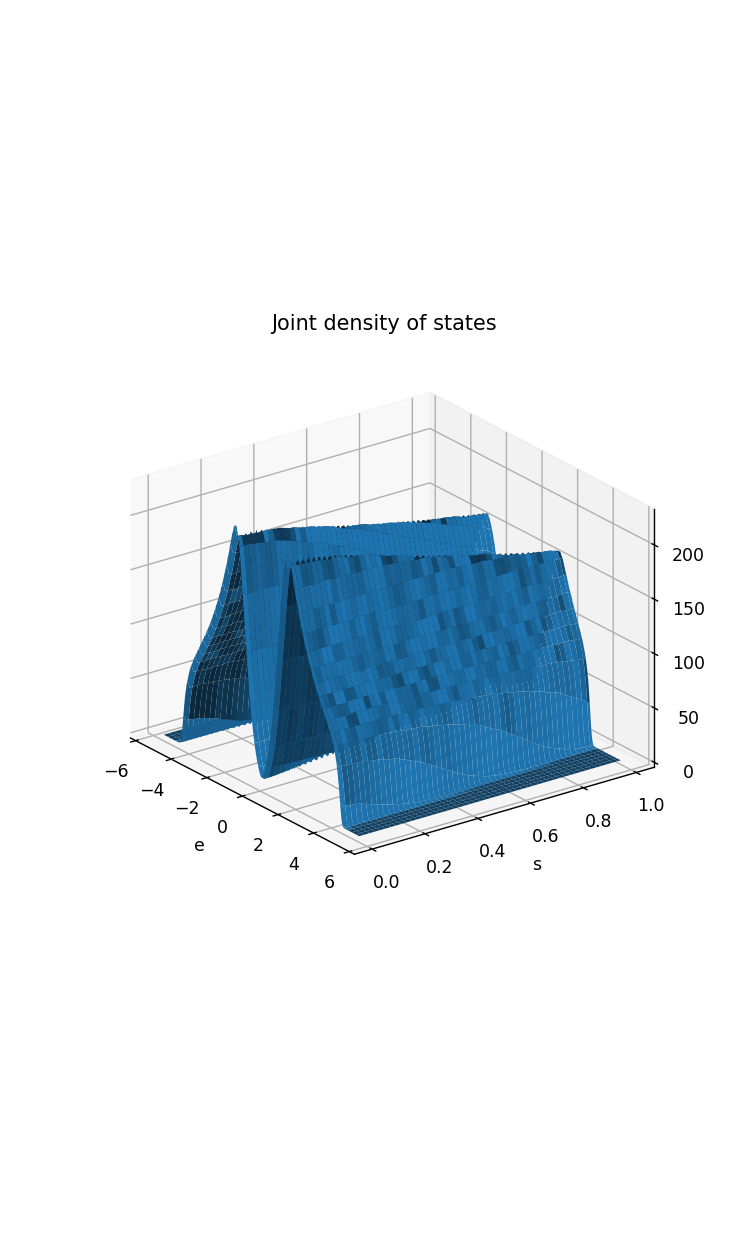

Total number of deltas included = 4116301.665


<IPython.core.display.Javascript object>


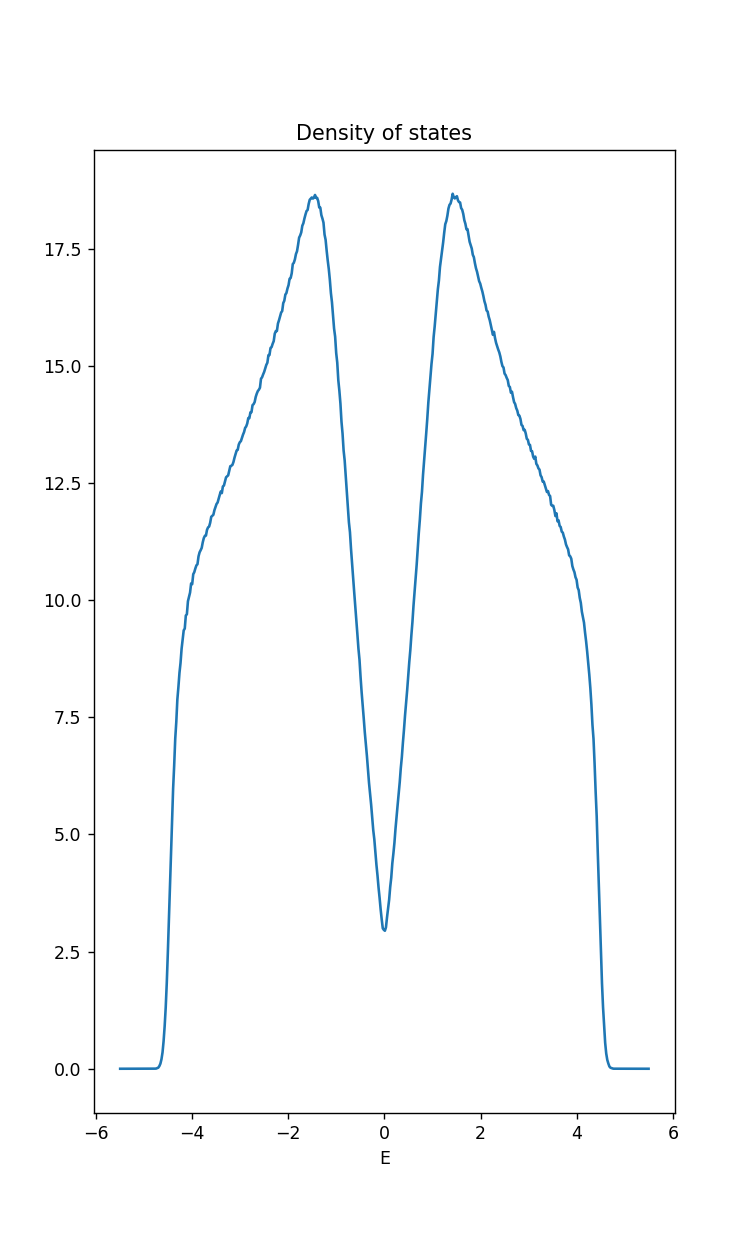

<IPython.core.display.Javascript object>


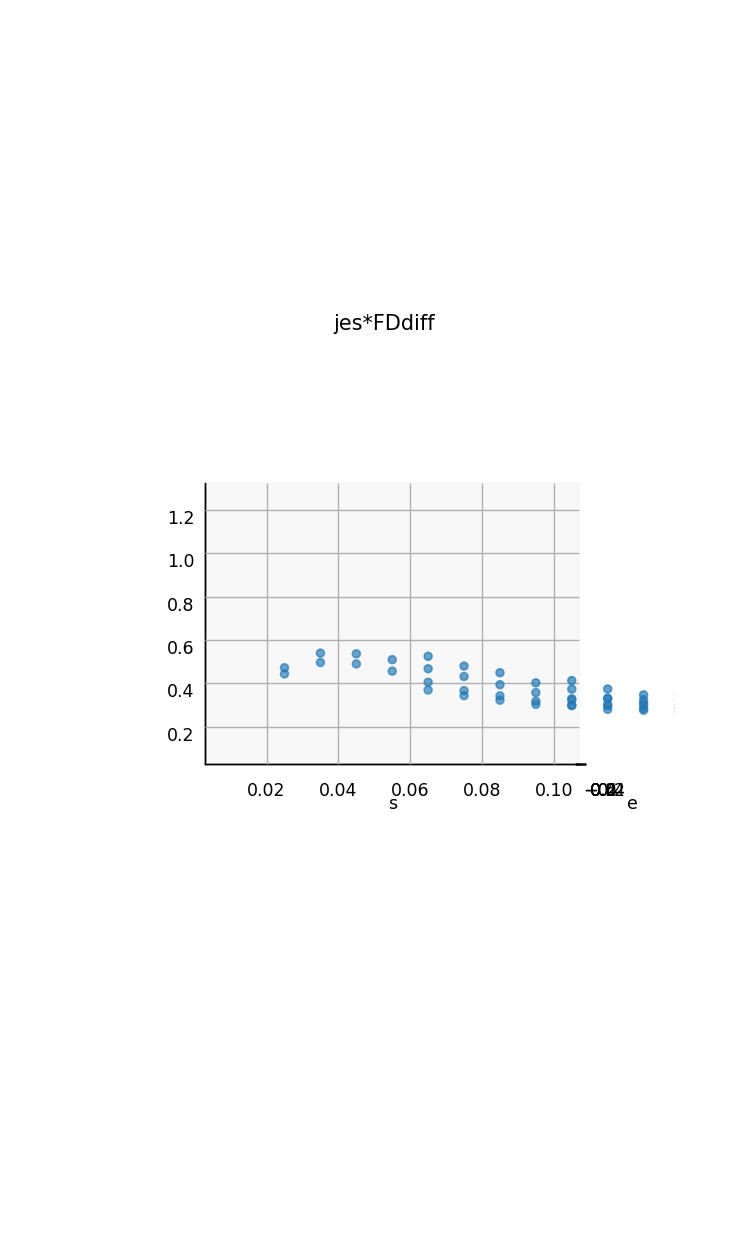

<IPython.core.display.Javascript object>


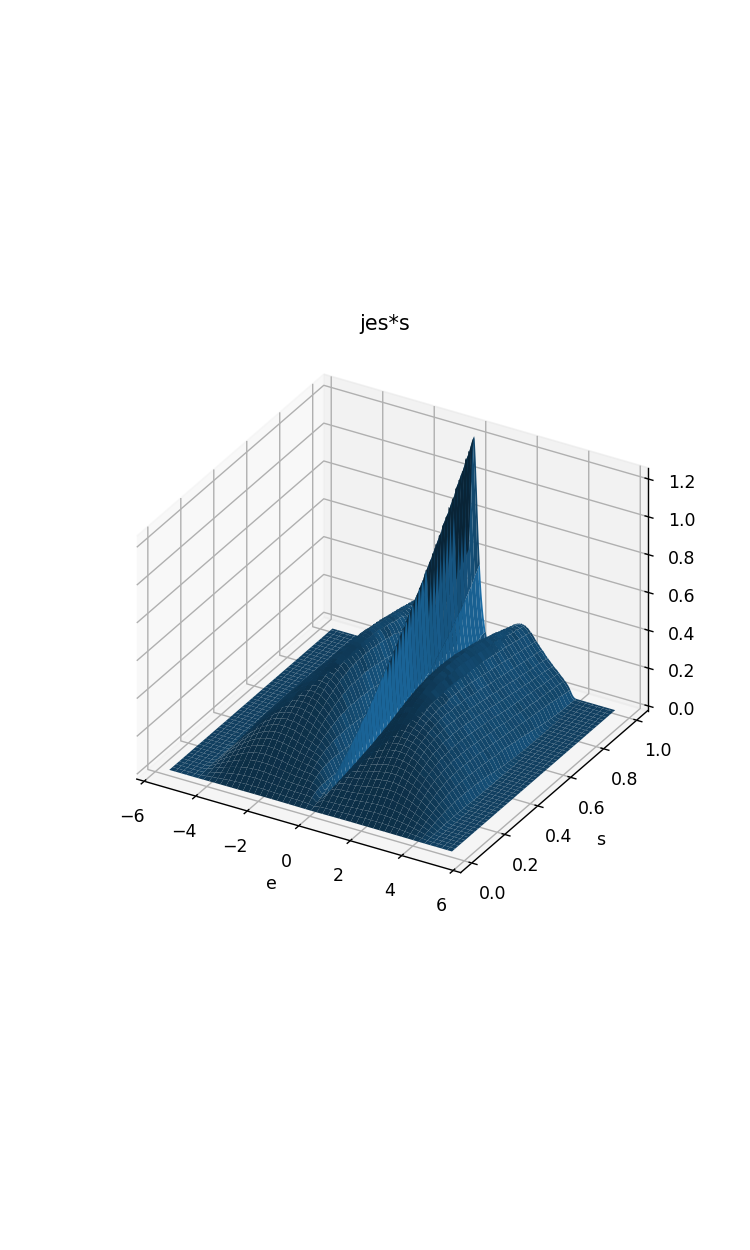

<IPython.core.display.Javascript object>


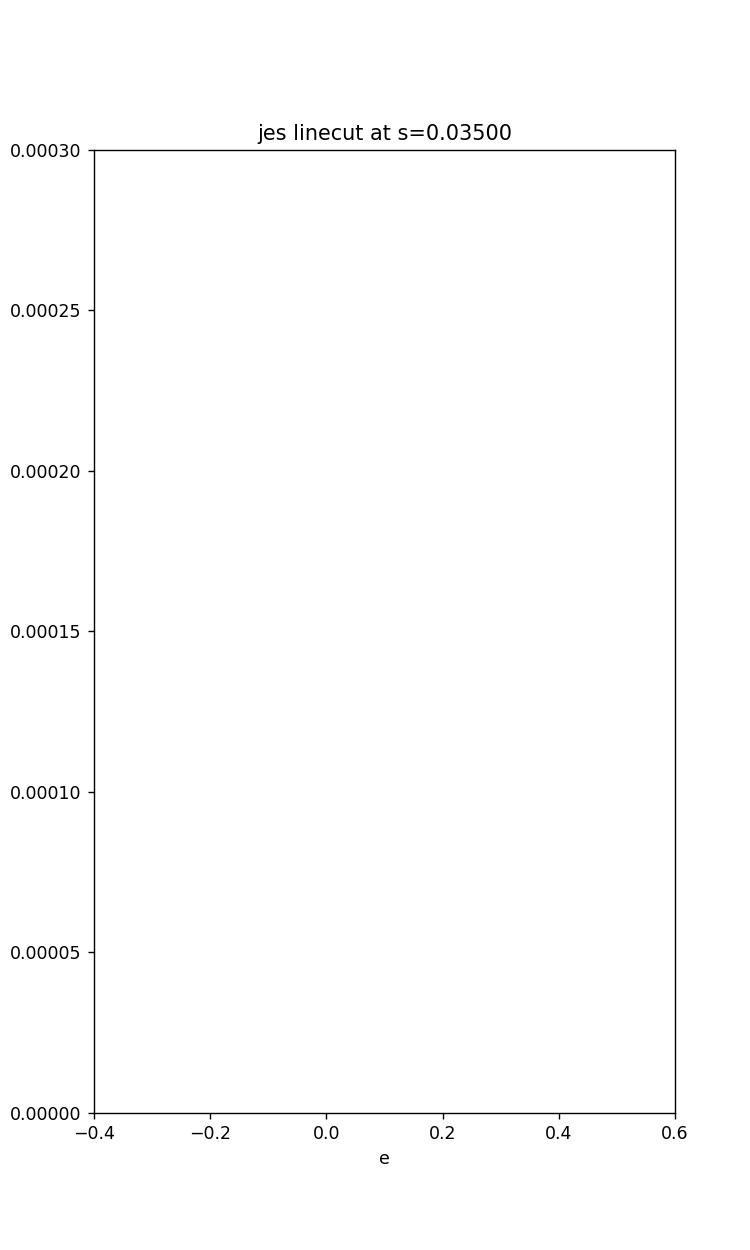

(0.0, 0.0003)

In [257]:
w_index_plot = 0
mu_index_plot = 0
s_index_plot = 3#int(ns/2)
emin_plot = emin_array[w_index_plot]
emax_plot = emax_array[w_index_plot]
ewidth = emax_plot-emin_plot
de = ewidth/ne
swidth = smax-smin
ds = swidth/ns
evec = np.linspace(emin_plot, emax_plot-de, ne) + de/2
svec = np.linspace(smin, smax-ds, ns) + ds/2
[ss, ee] = np.meshgrid(svec, evec)
print("w=%s" % w_list[w_index_plot])
print("mu=%s" % mu_list[mu_index_plot])
print("s=%s" % svec[s_index_plot])

fig1 = plt.figure(1, figsize=(6,10))
ax1 = plt.axes(projection='3d')
ax1.plot_surface(ee, ss, jes[:,:,w_index_plot])
ax1.set_title("jes")
ax1.set_xlabel("e")
ax1.set_ylabel("s")
'''
ax1.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
ax1.set_ylim([svec[0],svec[int(ns/10)]])
'''

fig2 = plt.figure(2, figsize=(6,10))
ax2 = plt.axes(projection='3d', proj_type = 'ortho')
zcutoff = 30
num_deltas_plot = num_deltas[:,:,w_index_plot]
#num_deltas_plot[num_deltas_plot>zcutoff] = None
ax2.plot_surface(ee, ss, num_deltas_plot)
ax2.set_title("Joint density of states")
ax2.set_xlabel("e")
ax2.set_ylabel("s")
'''
ax2.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
ax2.set_ylim([svec[0],svec[int(ns/10)]])
ax2.set_zlim([0,zcutoff])
'''
elev = 0
azim = 0
ax2.view_init(elev, azim)
print("Total number of deltas included = %s" % np.sum(num_deltas_plot))

fig3 = plt.figure(3, figsize=(6,10))
ax3 = plt.axes()
ax3.plot(evec, dos[:,w_index_plot])
ax3.set_title("Density of states")
ax3.set_xlabel("E")

fig4 = plt.figure(4, figsize=(6,10))
ax4 = plt.axes(projection='3d', proj_type = 'ortho')
jesxFDdiff = abs(np.multiply(jes[:,:,w_index_plot],np.multiply(FDfactor[:,:,mu_index_plot],ss)))
jesxFDdiff[jesxFDdiff==0] = None
ax4.scatter(ee, ss, jesxFDdiff)
ax4.set_title("jes*FDdiff")
ax4.set_xlabel("e")
ax4.set_ylabel("s")
ax4.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
ax4.set_ylim([svec[0],svec[int(ns/10)]])
elev = 0
azim = 0
ax4.view_init(elev, azim)

fig5 = plt.figure(5, figsize=(6,10))
ax5 = plt.axes(projection='3d', proj_type = 'ortho')
jesxs = abs(np.multiply(jes[:,:,w_index_plot],ss))
ax5.plot_surface(ee, ss, jesxs)
ax5.set_title("jes*s")
ax5.set_xlabel("e")
ax5.set_ylabel("s")

fig6 = plt.figure(6, figsize=(6,10))
ax6 = plt.axes()
ax6.plot(evec, jes[:,s_index_plot,w_index_plot], color="b", marker="o")
#ax6.plot(evec, jes[:,s_index_plot,w_index_plot+1], color="r")
ax6.set_title("jes linecut at s=%.5f" % svec[s_index_plot])
ax6.set_xlabel("e")
ax6.set_ylabel("s")
ax6.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
ax6.set_ylim([0,0.0003])


In [95]:
w_index_plot1 = 1
w_index_plot2 = 2
mu_index_plot = 0
print("w=%s,%s" % (w_list[w_index_plot1],w_list[w_index_plot2]))
print("mu=%s" % mu_list[mu_index_plot])
print("s=%s" % svec[s_index_plot])

if emin_array[w_index_plot1]==emin_array[w_index_plot2]:
    fig7 = plt.figure(7, figsize=(6,10))
    ax7 = plt.axes(projection='3d')
    ax7.plot_surface(ee, ss, jes[:,:,w_index_plot1])
    jesaxlim = ax7.get_zlim()
    ax7.plot_surface(ee, ss, jes[:,:,w_index_plot1]-jes[:,:,w_index_plot2])
    ax7.set_title("jes difference")
    ax7.set_xlabel("e")
    ax7.set_ylabel("s")
    ax7.set_zlim(jesaxlim)
    #ax7.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
    
    fig8 = plt.figure(8, figsize=(12,10))
    ax8a, ax8b = fig8.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
    ax8a.plot_surface(ee, ss, num_deltas[:,:,w_index_plot1])
    ax8b.plot_surface(ee, ss, num_deltas[:,:,w_index_plot2])
    '''
    ax7 = plt.axes(projection='3d')
    jesaxlim = ax7.get_zlim()
    ax7.plot_surface(ee, ss, jes[:,:,w_index_plot1]-jes[:,:,w_index_plot2])
    ax7.set_title("jes difference")
    ax7.set_xlabel("e")
    ax7.set_ylabel("s")
    ax7.set_zlim(jesaxlim)
    #ax7.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
    '''
else:
    print("Plots must be for the same w!")

w=1.0,1.5
mu=0.1
s=0.0035
Plots must be for the same w!


Plot all DoS curves

<IPython.core.display.Javascript object>


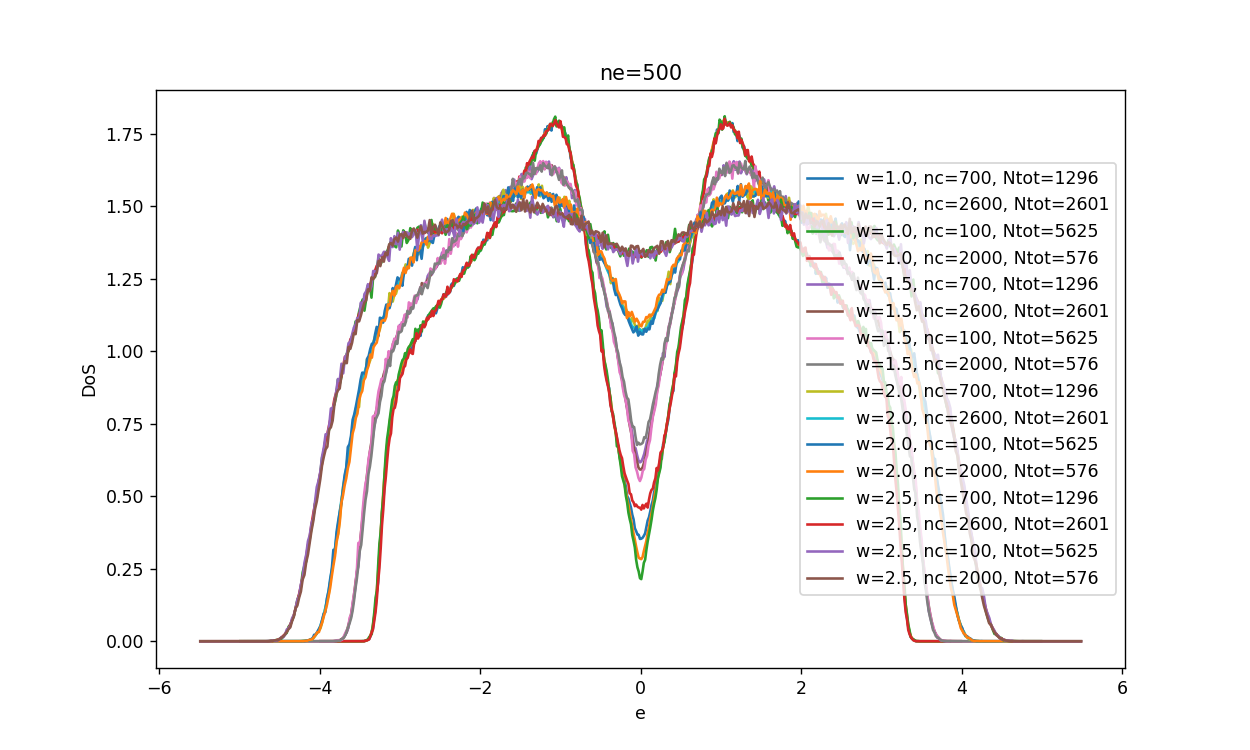

In [387]:
plt.figure(441,figsize=(10,6))
ax441 = plt.axes()
#plt.plot(s_vec, sig[:,1,0])
for kf in np.arange(nf):
    ewidth = emax[kf]-emin[kf]
    de = ewidth/ne
    evec = np.linspace(emin[kf], emax[kf]-de, ne) + de/2
    ax441.plot(evec, dos[:,kf], label=("w=%s, nc=%s, Ntot=%s" % (w_list[kf],nconfig_list[kf],Ntot_list[kf])))
ax441.set_title("ne=%d" % ne)
ax441.set_xlabel("e")
ax441.set_ylabel("DoS")
ax441.legend(loc=5)

Compare Jes and JDoS

<IPython.core.display.Javascript object>


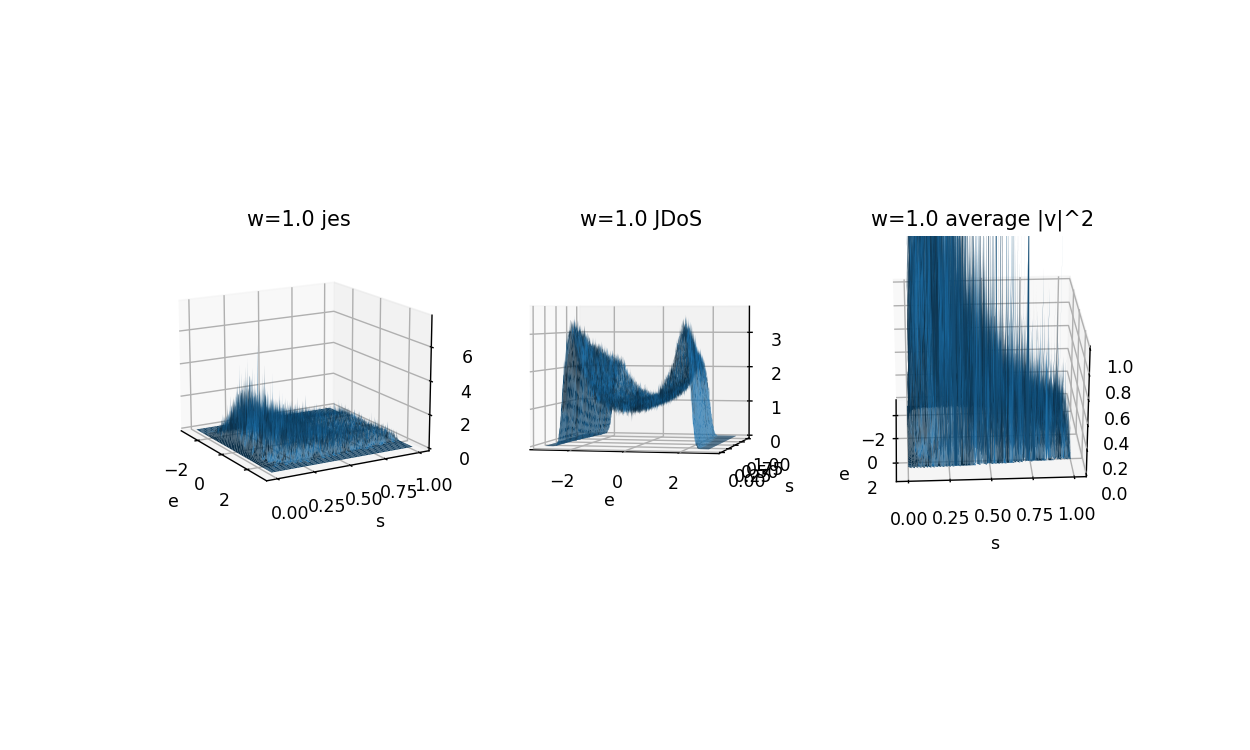

<ipython-input-137-edcf4e3c97c0>:8: RuntimeWarning: invalid value encountered in true_divide
  axv.plot_surface(ee, ss, np.divide( jes[:,:,w_index_plot] , num_deltas[:,:,w_index_plot] ))
<ipython-input-137-edcf4e3c97c0>:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  axv.plot_surface(ee, ss, np.divide( jes[:,:,w_index_plot] , num_deltas[:,:,w_index_plot] ))


(0.0, 1.0)

In [137]:
w_index_plot = 0
figjesjdos = plt.figure(200, figsize=(10,6))
axjes = plt.subplot(1,3,1, projection="3d")
axjdos = plt.subplot(1,3,2, projection="3d")
axv = plt.subplot(1,3,3, projection="3d")
axjes.plot_surface(ee, ss, jes[:,:,w_index_plot])
axjdos.plot_surface(ee, ss, num_deltas[:,:,w_index_plot])
axv.plot_surface(ee, ss, np.divide( jes[:,:,w_index_plot] , num_deltas[:,:,w_index_plot] ))
(azim, elev) = (-30, 15)
for ax in [axjes, axjdos, axv]:
    #ax.set_xlim([mu_list[mu_index_plot]-smax/2,mu_list[mu_index_plot]+smax/2])
    #ax.set_ylim([0, 0.1])
    ax.set_xlabel("e")
    ax.set_ylabel("s")
    ax.view_init(elev, azim)
axjes.set_title("w=%s jes" % (w_list[w_index_plot]))
axjdos.set_title("w=%s JDoS" % (w_list[w_index_plot]))
axv.set_title("w=%s average |v|^2" % (w_list[w_index_plot]))
axv.set_zlim([0,1])

#(laz, lel) = (-35, 90)
#mpl.colors.LightSource(laz,lel)

Plot jes for various disorders beside one another

<IPython.core.display.Javascript object>


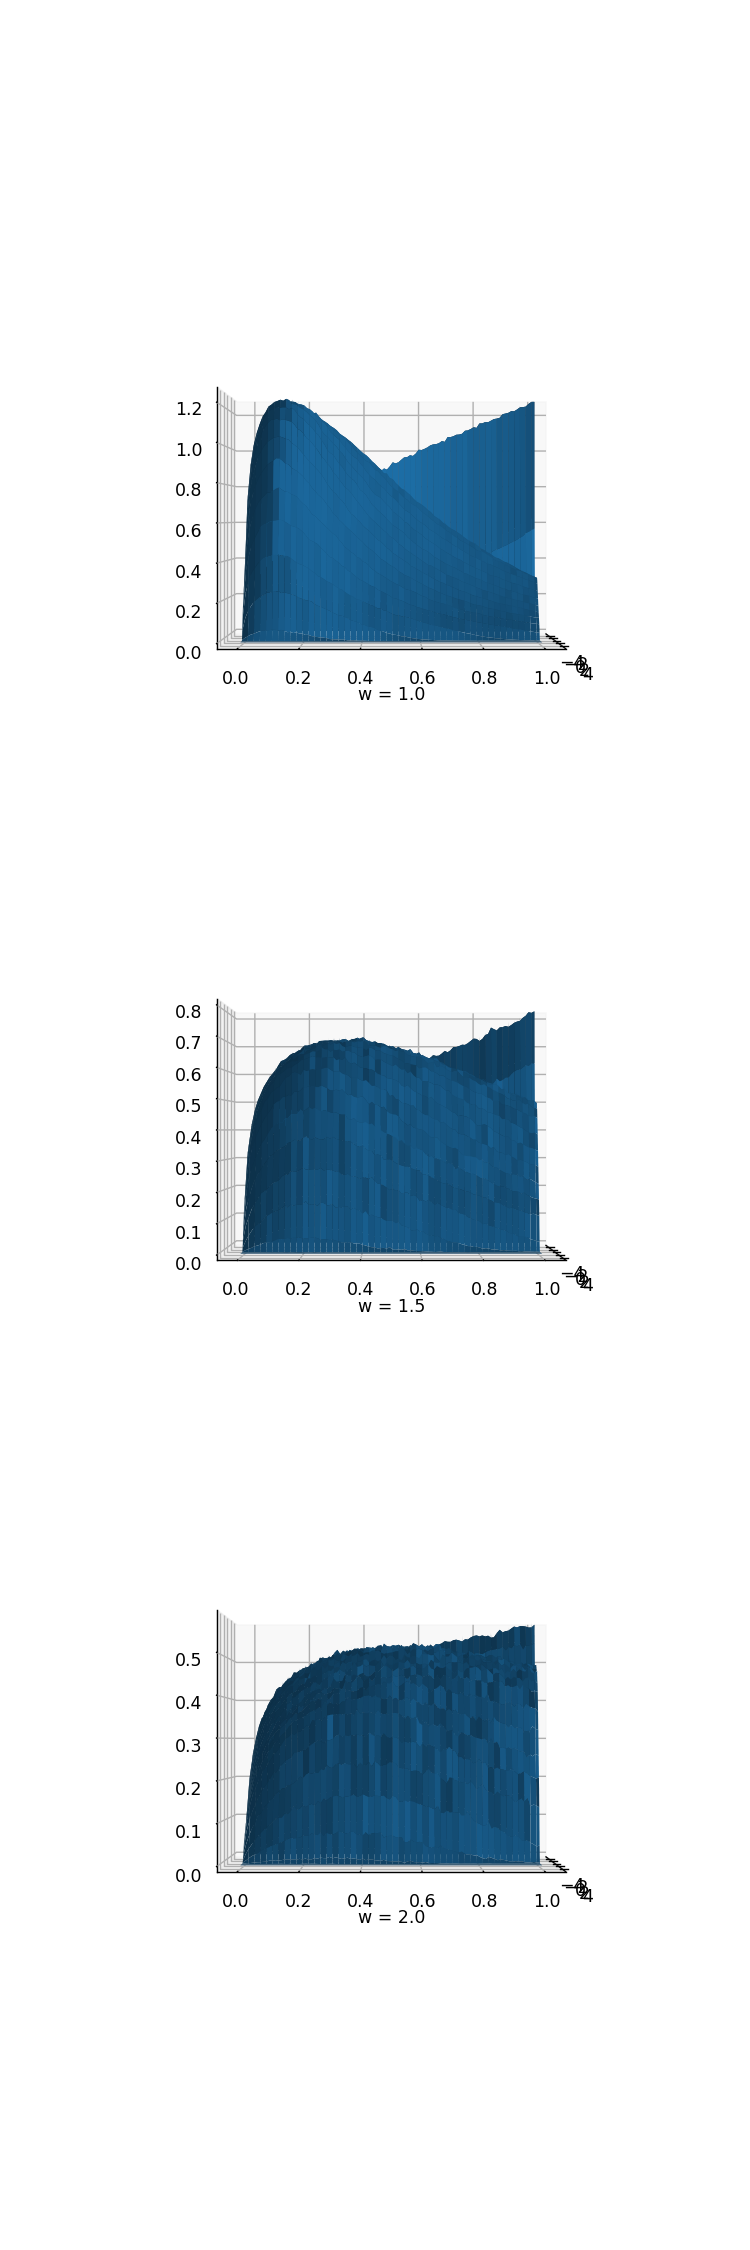

In [310]:

figwjes = plt.figure(300, figsize=(6, 6*nw))
(azim, elev) = (0, 0)
for kw,w in enumerate(w_list):
    ax = plt.subplot(nw, 1, kw+1, projection="3d")
    ax.plot_surface(ee, ss, jes[:,:,kw])
    ax.set_ylabel("w = %s" % w)
    ax.view_init(elev, azim)


Find useful subsets of files

In [358]:
wfind = 1

wf_indices = [kw for kw,w in enumerate(w_list) if w==float(wfind)]
Ntot_lw = [Ntot_list[kw] for kw in wf_indices]
nconfig_lw = [nconfig_list[kw] for kw in wf_indices]
note_lw = [note_list[kw] for kw in wf_indices]
nwsub = len(wf_indices)

print("Unit cells, configs, and notes for each file with w = %s:" % wfind)
print("Unit cells: %s" % Ntot_lw)
print("Configs: %s" % nconfig_lw)
print("Notes: %s" % note_lw)

Ntotfind = 2601

Ntotf_indices = [kN for kN,N in enumerate(Ntot_list) if N==Ntotfind]
w_lN = [w_list[kN] for kN in Ntotf_indices]
nconfig_lN = [nconfig_list[kN] for kN in Ntotf_indices]
note_lN = [note_list[kN] for kN in Ntotf_indices]
nNsub = len(Ntotf_indices)

print(Ntotf_indices)
print("Unit cells, configs, and notes for each file with Ntot = %s:" % Ntotfind)
print("Disorder: %s" % w_lN)
print("Configs: %s" % nconfig_lN)
print("Notes: %s" % note_lN)

Unit cells, configs, and notes for each file with w = 1:
Unit cells: [2601]
Configs: [2600]
Notes: ['']
[0, 1, 2]
Unit cells, configs, and notes for each file with Ntot = 2601:
Disorder: [1.0, 1.5, 2.0]
Configs: [2600, 2600, 2600]
Notes: ['', '', '']


Plot together all conductivities in the w and Ntot subsets

<IPython.core.display.Javascript object>


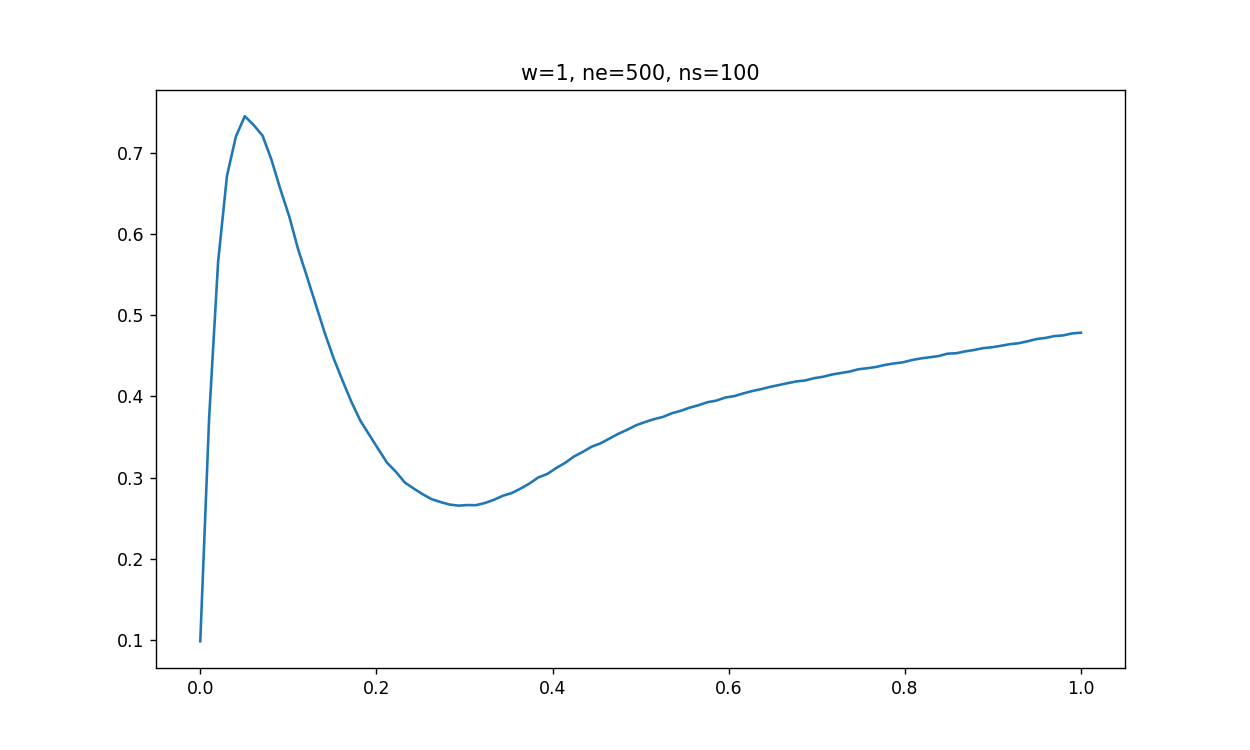

<IPython.core.display.Javascript object>


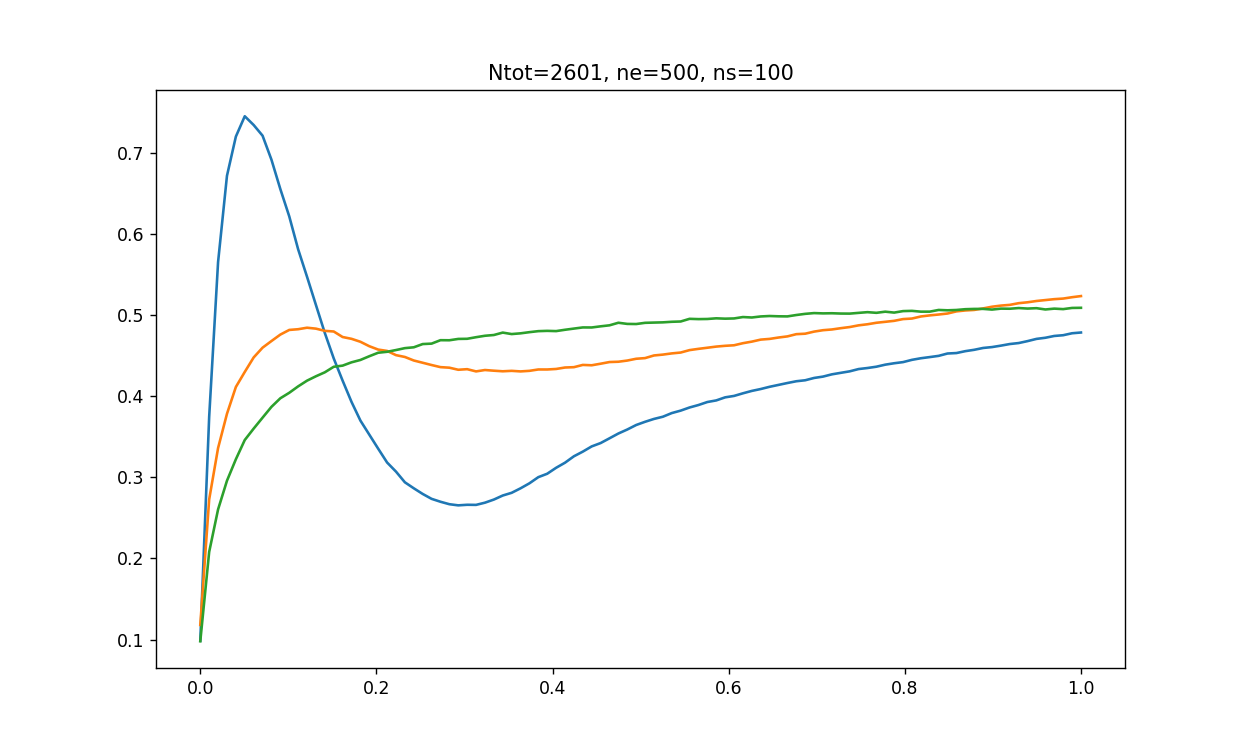

Text(0.5, 1.0, 'Ntot=2601, ne=500, ns=100')

In [370]:
sig_wsub = np.zeros((ns,nwsub,nmu))
for kw in np.arange(nwsub):
    sig_wsub[:,kw,:] = sigsplined[:,wf_indices[kw],:]

sig_Nsub = np.zeros((ns,nNsub,nmu))
for kN in np.arange(nNsub):
    sig_Nsub[:,kN,:] = sigsplined[:,Ntotf_indices[kN],:]

kmu_plot = 0

fig70 = plt.figure(70, figsize=(10,6))
ax70 = plt.axes()
for kw in np.arange(nwsub):
    ax70.plot(svec, sigsplined[:,wf_indices[kw],kmu_plot], label=("Ntot=%s, nc=%s" % (Ntot_lw[kw], nconfig_lw[kw])))
ax70.set_title("w=%s, ne=%d, ns=%d" % (wfind,ne,ns))

fig71 = plt.figure(71, figsize=(10,6))
ax71 = plt.axes()
for kN in np.arange(nNsub):
    ax71.plot(svec, sigsplined[:,Ntotf_indices[kN],kmu_plot], label=("w=%s, nc=%s" % (w_lN[kN], nconfig_lN[kN])))
ax71.set_title("Ntot=%s, ne=%d, ns=%d" % (Ntotfind,ne,ns))


In [83]:
maxsigs = np.zeros((nf,nmu))
for kf, w in enumerate(w_list):
    for kmu, mu in enumerate(mu_list):
        #print("mu = %s" % mu)
        #print("w = %s" % w)
        #print("max conductivity = %s" % sigsplined[:,kf,kmu].max())
        maxsigs[kf,kmu] = sigsplined[:,kf,kmu].max()

print(w_list)
print(Ntot_list)
print(mu_list)
print(maxsigs)

[1.0, 1.5, 2.0, 2.5]
[1296, 1296, 1296, 1296]
[0.2, 0.4, 0.6]
[[0.67942031 0.80726108 0.87911057]
 [0.5196007  0.55694951 0.60944171]
 [0.50651637 0.48931585 0.50079672]
 [0.46737521 0.4608452  0.45420779]]


<IPython.core.display.Javascript object>


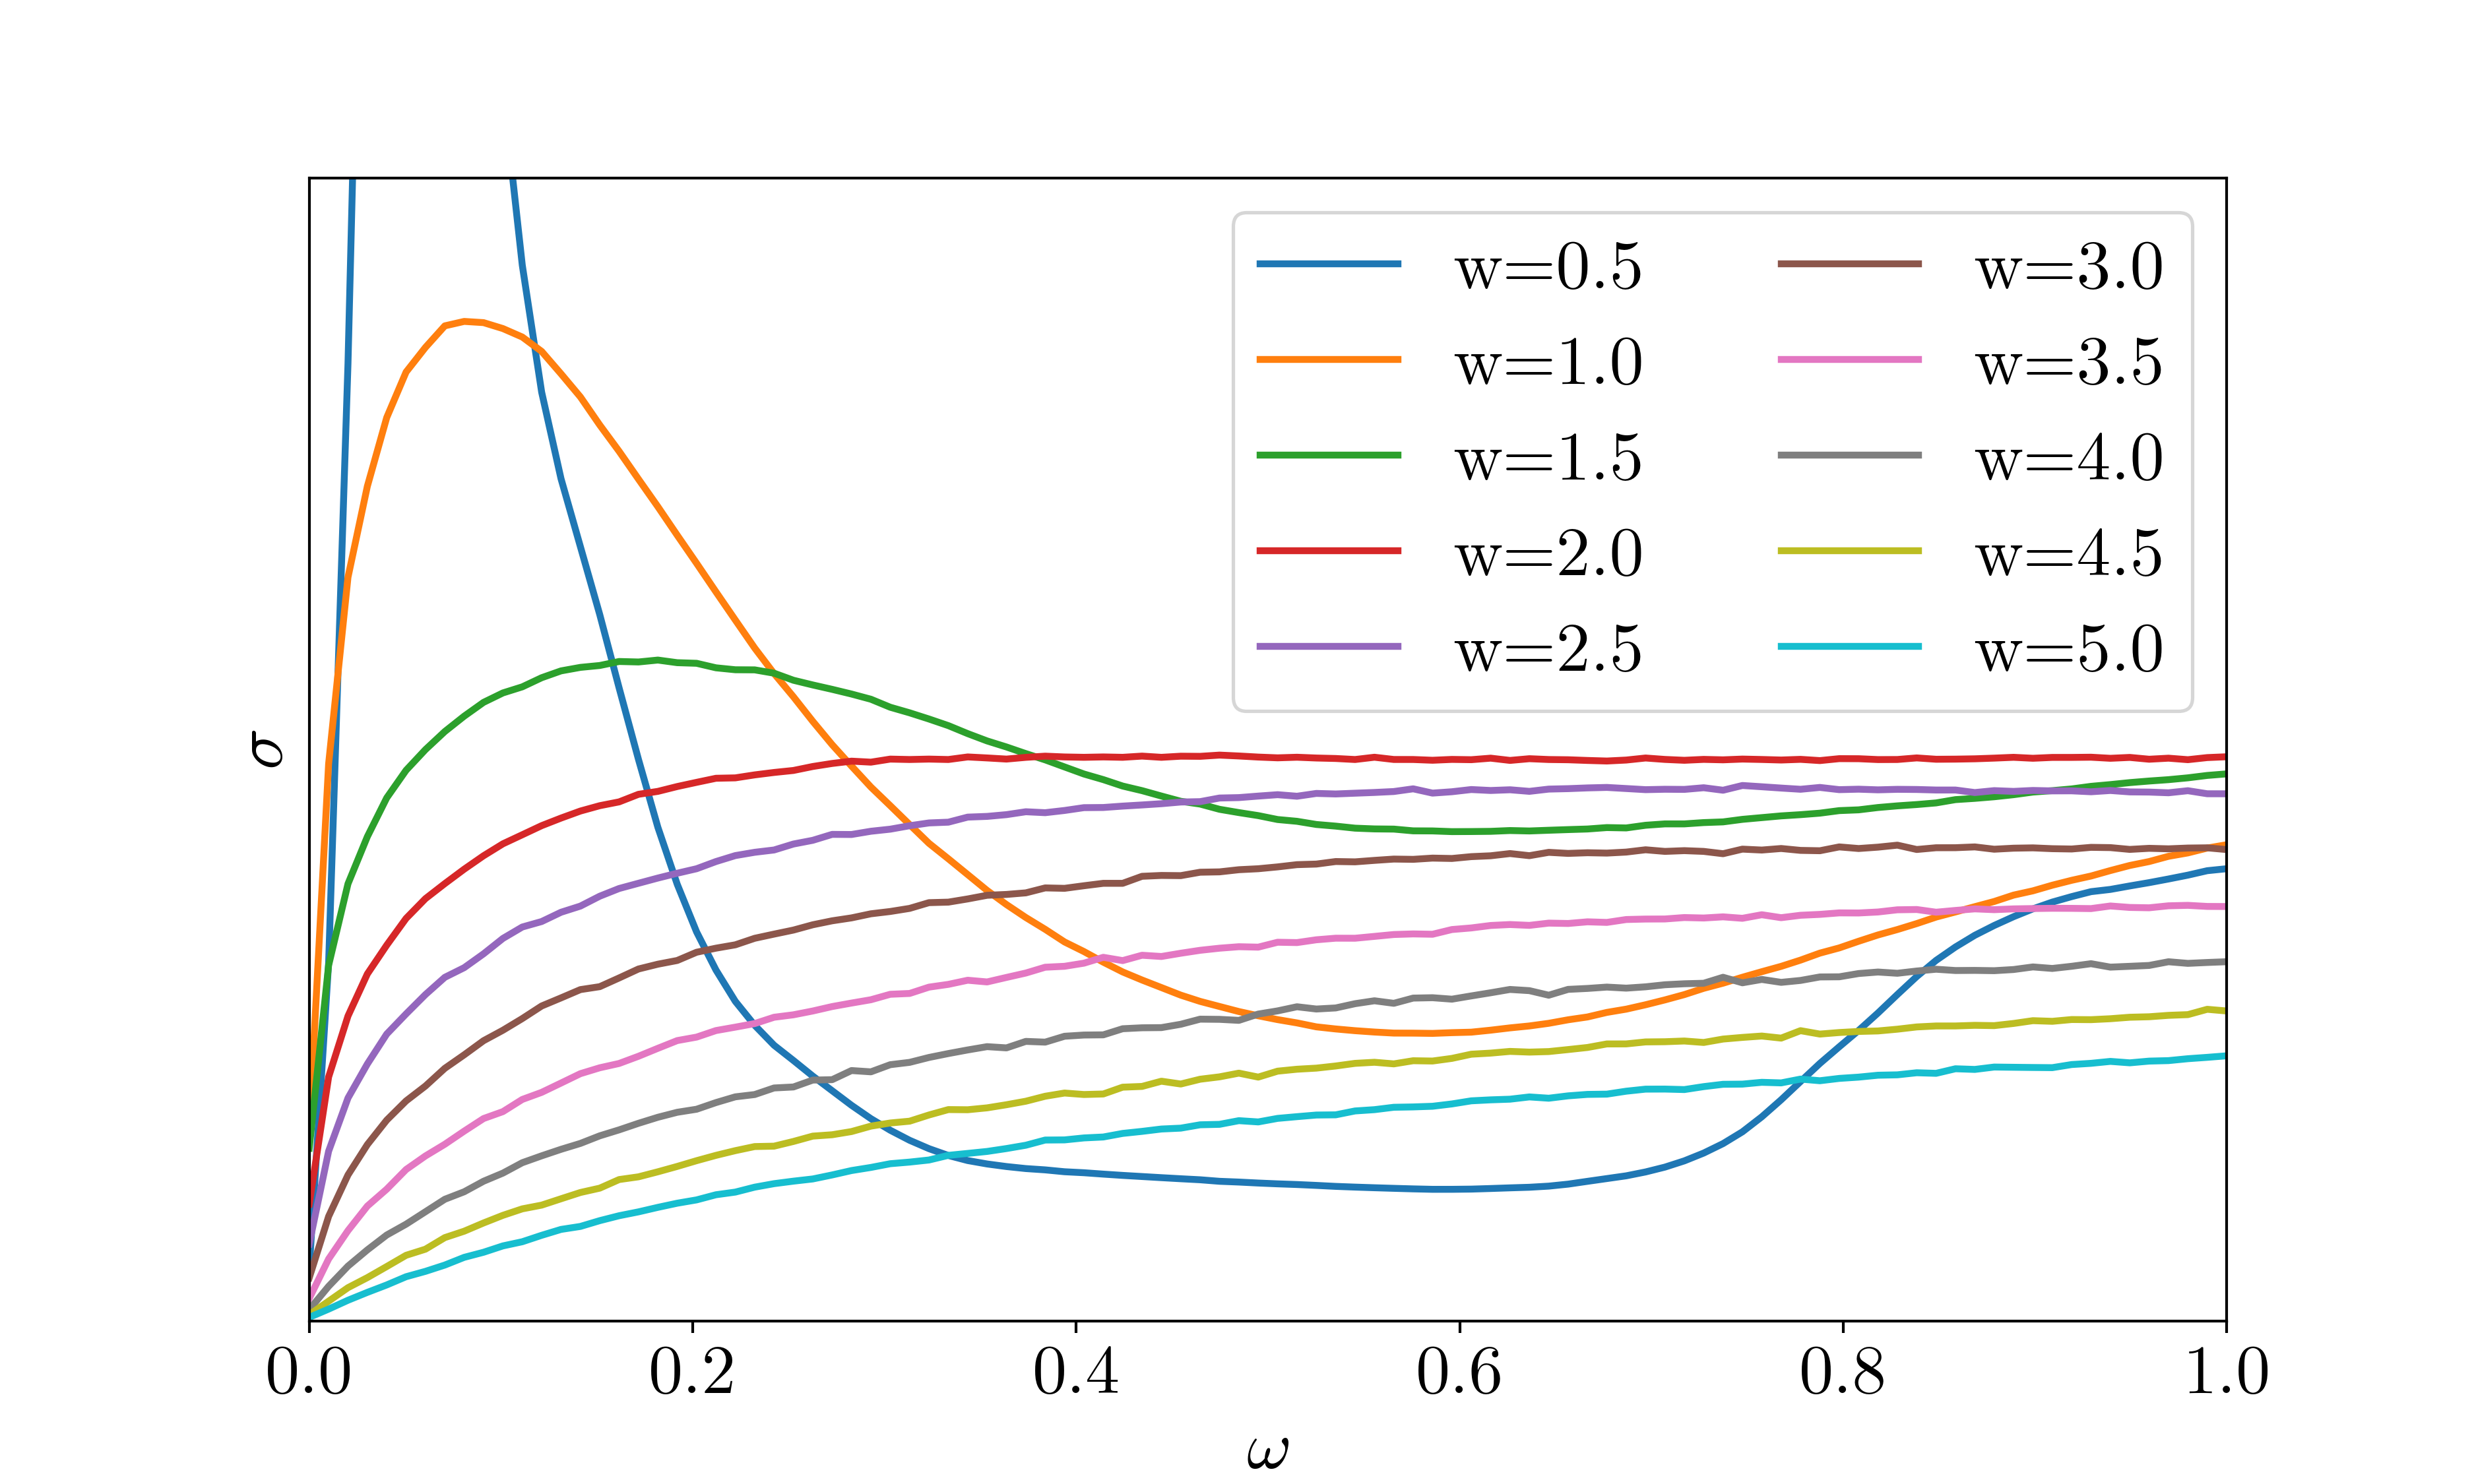

In [69]:
kmu_plot = 0

from matplotlib import rcParams
(rcParams["font.family"],rcParams["mathtext.fontset"]) = ("Latin Modern Math","cm")
mag = 1
plt.rc("font", size=mag*20)
plt.rc("figure", figsize=(mag*10,mag*6))
plt.rc("lines", linewidth=mag*2)

mpl.rcParams['figure.dpi'] = 300

svec = np.linspace(smin, smax, ns)
plt.figure(987,figsize=(10,6))
for kf in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    plt.plot(svec, sigsplined[:,kf,kmu_plot], label=("w=%s" % w_list[kf]))
ax74 = plt.gca()
ax74.set_xlabel("$\omega$")
ax74.set_ylabel("$\sigma$")
ax74.set_xlim([smin, smax])
ax74.set_ylim([0, 0.02])
ax74.tick_params(left=False, labelleft=False)
plt.legend(loc=1, ncol=2)
#plt.legend(loc=1)


<IPython.core.display.Javascript object>


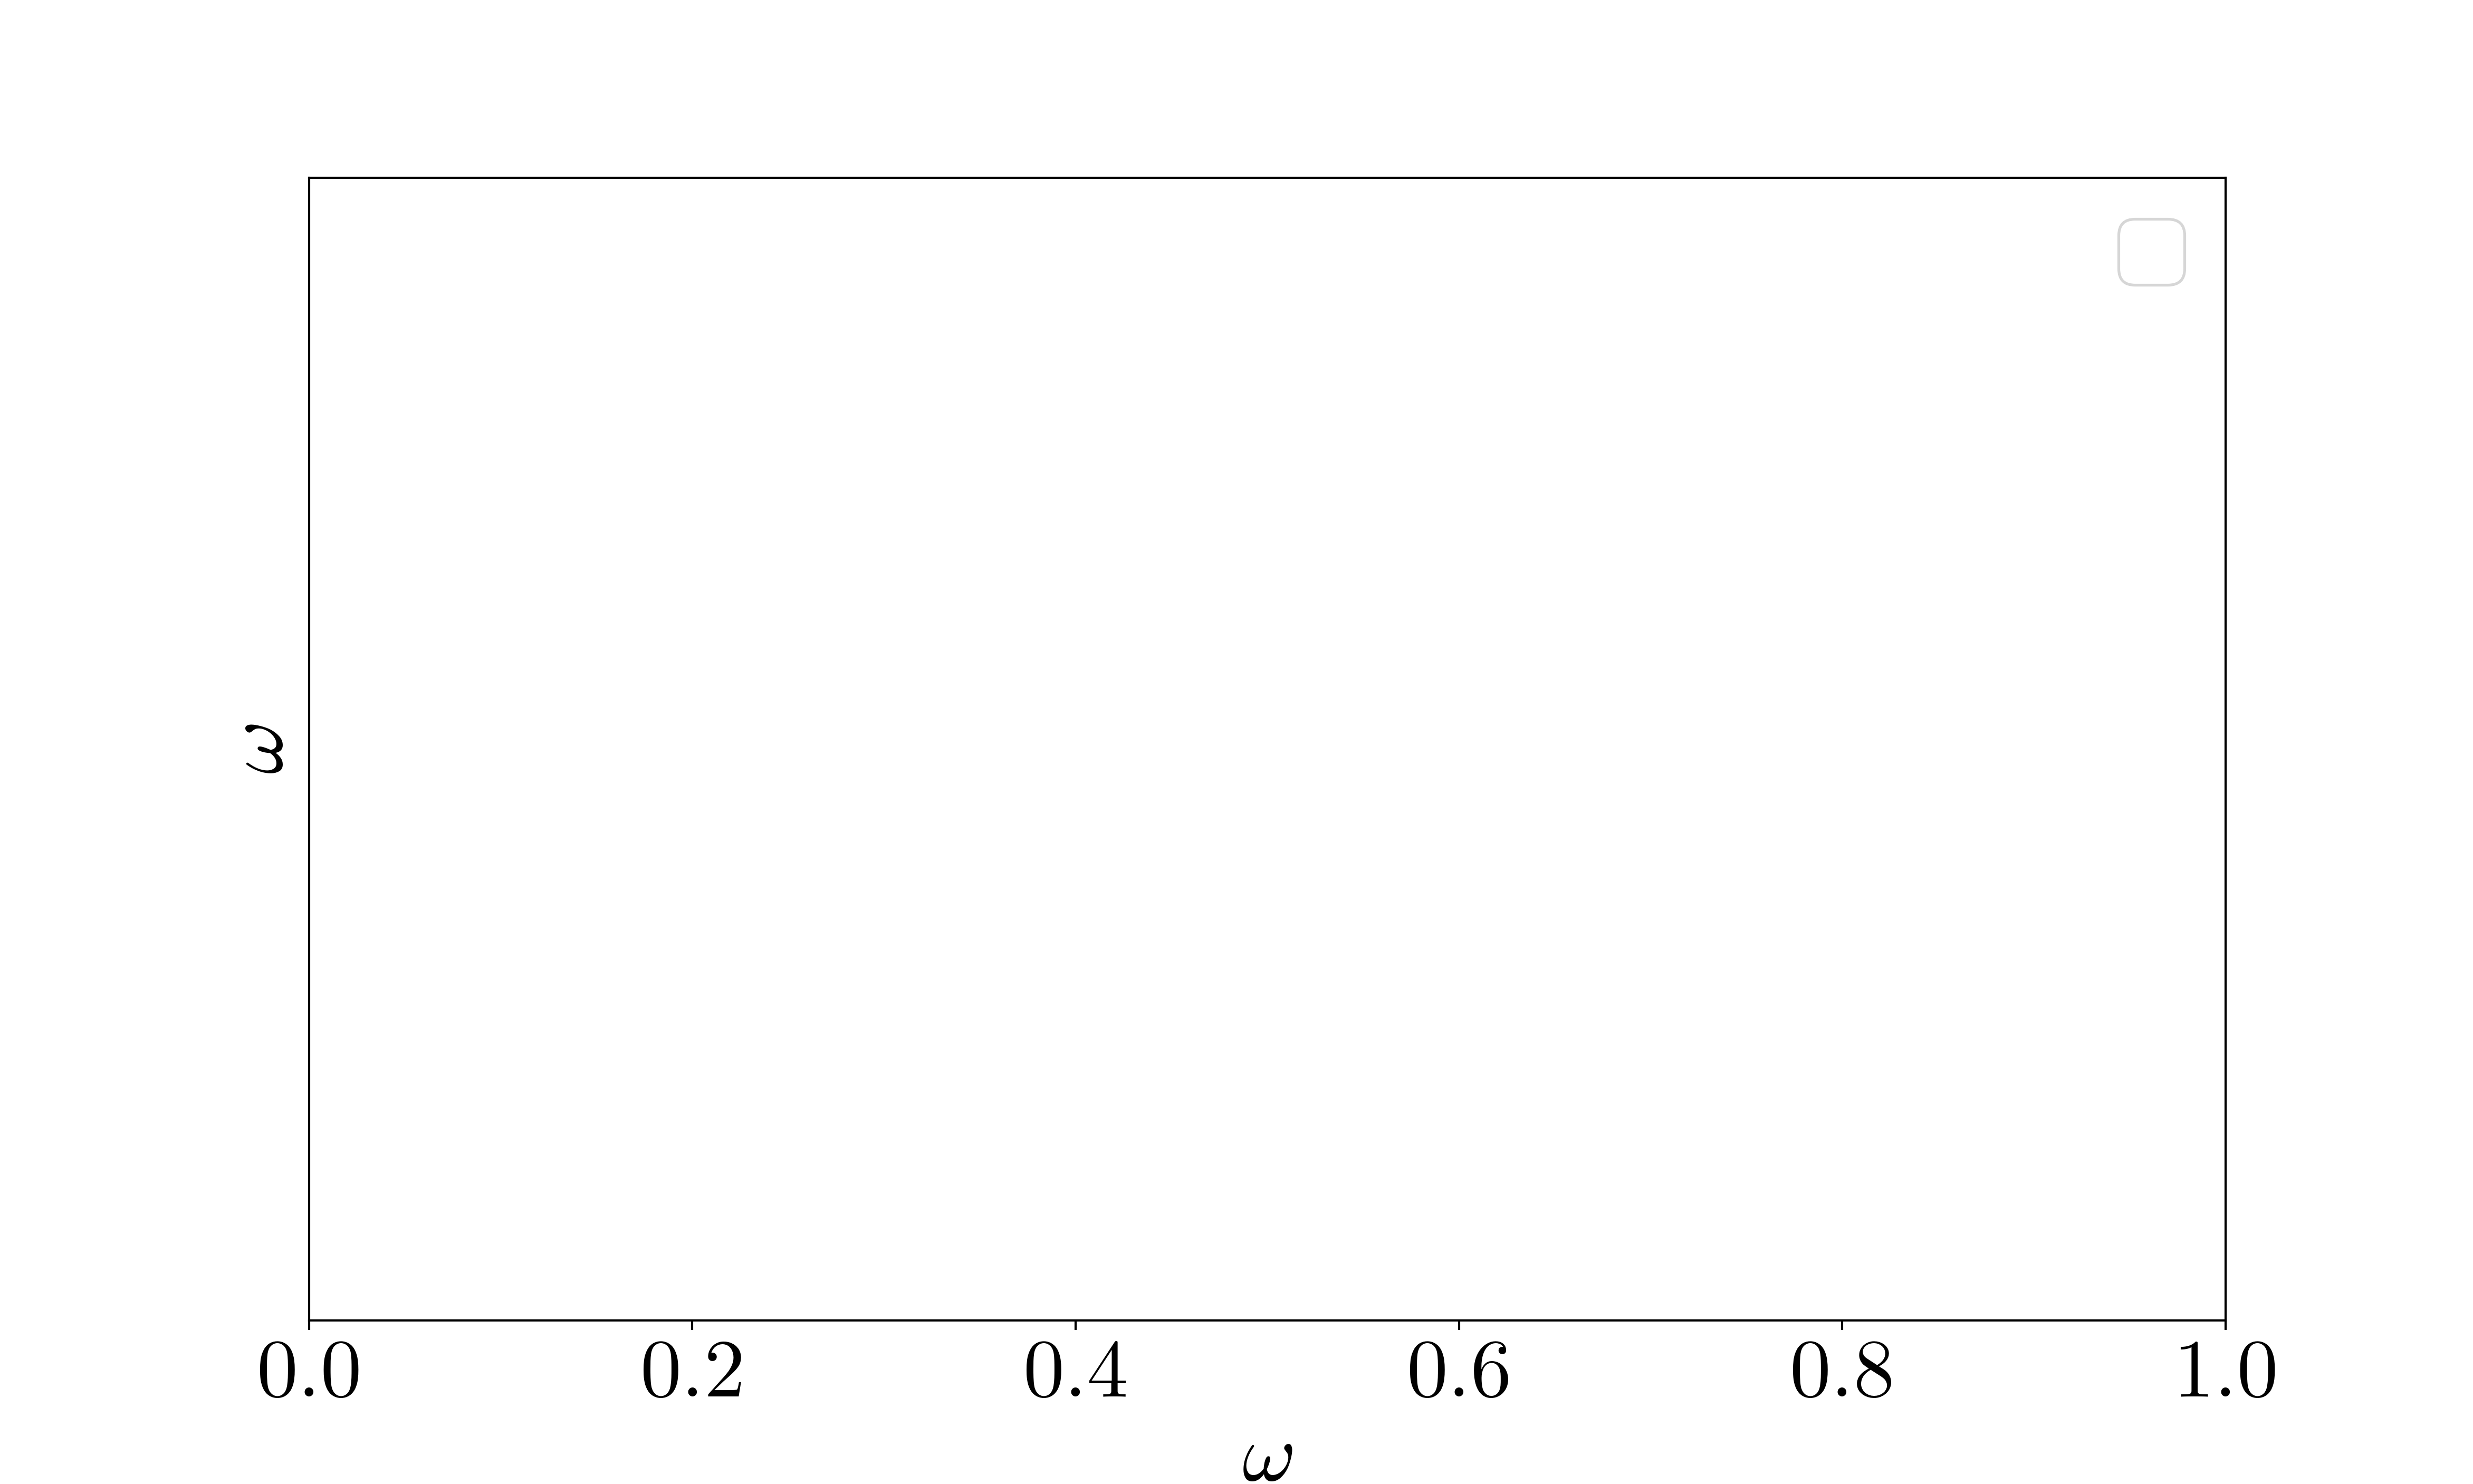

No handles with labels found to put in legend.


In [130]:
kmu_plot = 0

from matplotlib import rcParams
(rcParams["font.family"],rcParams["mathtext.fontset"]) = ("Latin Modern Math","cm")
mag = 1
plt.rc("font", size=mag*30)
plt.rc("figure", figsize=(mag*10,mag*6))
plt.rc("lines", linewidth=mag*2)

mpl.rcParams['figure.dpi'] = 300
svec = np.linspace(smin, smax, ns)
plt.figure(989,figsize=(10,6))
#plt.plot(s_vec, sig[:,1,0])
#for kf in [4, 0, 2, 3, 1]:
#    plt.plot(svec, sigsplined[:,kf,kmu_plot], label=("N=%s" % Ntot_list[kf]))
ax75 = plt.gca()
ax75.set_xlabel("$\omega$")
ax75.set_ylabel("$\omega$")
ax75.set_xlim([smin, smax])
ax75.set_ylim([0, 0.0205])
ax75.tick_params(left=False, labelleft=False)
plt.legend(loc=1)
